In [11]:
from collections import defaultdict
from typing import Dict
from pathlib import Path
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [12]:
%config InlineBackend.figure_format='retina'


In [13]:
structures = pd.read_pickle('../datasets/processed/dichalcogenides_x1s6_202109_MoS2/data.pickle.gz')

In [14]:
targets = pd.read_csv(Path('../datasets/processed/dichalcogenides_x1s6_202109_MoS2/targets.csv.gz'), index_col=0) * 1000
folds = pd.read_csv(Path('../datasets/experiments/MoS2-plain-cv/folds.csv'), index_col=0)
targets.columns = pd.MultiIndex.from_product([['DFT'], targets.columns])
targets = targets.assign(folds=folds)


In [81]:
exp_dir_name_mapper = {
    'MoS2-plain-cv': 'MEGNet',
    'MoS2-plain-cv-catboost': 'Catboost+Matminer',
    'MoS2-plain-cv-gemnet': 'GemNet',
    'MoS2-plain-cv-schnet': 'SchNet',
}

exp_name_mapper = {
    'megnet-full.csv.gz': 'MEGNet-Full',
    'megnet-full-z.csv.gz': 'MEGNet-Full-Z',
    'megnet-sparse.csv.gz': 'MEGNet-Sparse',
    'megnet-sparse-z.csv.gz': 'MEGNet-Sparse-Z',
    'megnet-sparse-z-werespecies.csv.gz': 'MEGNet-Sparse-Z-were',
    'megnet-sparse-eos.csv.gz': 'MEGNet-Sparse-EOS',
    'catboost-test.csv.gz': 'Catboost+Matminer',
    'schnet-full.csv.gz': 'SchNet',
    'gemnet-full.csv.gz': 'GemNet',
    # "['formation_energy_per_site', 'homo']": "Formation-energy+HOMO",
    # 'megnet-sparse-eos-multitarget.csv.gz': "MEGNet-Sparse-EOS-Multi-target",
    'megnet-full-eos.csv.gz': "MEGNet-Full-EOS"

}


target_name_pretty_mapper = {
    'homo': 'HOMO',
    'lumo': 'LUMO',
    'band_gap': 'Bandgap',
    'formation_energy_per_site': 'Formation energy per site',
    
}

target_short_name_pretty_mapper = {
    'homo': 'HOMO',
    'lumo': 'LUMO',
    'band_gap': 'Bandgap',
    'formation_energy_per_site': 'Formation',
    "['formation_energy_per_site', 'homo']": 'Formation(+HOMO)',
    'predicted_formation_energy_per_site_test': 'formation_energy_per_site',
    'predicted_homo_test': 'HOMO',
}

In [82]:
predictions = Path('../datasets/predictions').resolve()
predictions = list(predictions.rglob('*.csv.gz'))
# Filter out other directories based on the mapper above
# file.parts[-3] correspond to directory name
predictions = list(filter(
    lambda file: file.parts[-3] in exp_dir_name_mapper.keys() and file.name in exp_name_mapper.keys(),
    predictions
))


In [83]:
data = defaultdict(dict)
for file in predictions:
    exp_name = exp_name_mapper.get(file.name)
    # target_name = target_name_mapper.get(file.parts[-2]) 
    target_name = file.parts[-2]
    # if target_name == "['formation_energy_per_site', 'homo']":
    #     _d = pd.read_csv(file, index_col=0) * 1000
    #     _d['lumo'] = np.zeros_like(_d['predicted_homo_test']) #* np.nan
    #     _d['band_gap'] = np.zeros_like(_d['predicted_homo_test']) #* np.nan
    #     for col_name, d in _d.groupby(level=0, axis=1):
    #         target_name = target_short_name_pretty_mapper[col_name]
    #         data[exp_name][target_name] = d
    # else:    
    df = pd.read_csv(file, index_col=0) * 1000
    # if exp_name == 'MEGNet-Sparse-EOS-Multi-target':
    #     for col_name, d in df.groupby(level=0, axis=1):
    #         target_name = target_short_name_pretty_mapper[col_name]
    #         data[exp_name][target_name] = d
    #     data[exp_name]['humo'] = pd.DataFrame({'humo': np.zeros_like(df['predicted_homo_test']) * np.nan}, index=df.index)
    #     data[exp_name]['lumo'] = pd.DataFrame({'lumo': np.zeros_like(df['predicted_homo_test']) * np.nan}, index=df.index)
    data[exp_name][target_name] = df

In [84]:
def make_df_from_trial(data: dict, name: str):
    df = pd.concat(data, axis=1)
    df.columns = df.columns.droplevel(-1)
    # Append each attribute with _pred
    # df = df.add_suffix('_pred')
    # Add Higher level index (name of experiment)
    df.columns = pd.MultiIndex.from_product([[name], df.columns])
    # [[name] * len(df.columns), [col + ' predicted' for col in df.columns]]
    return df

In [85]:
predictions = pd.concat([make_df_from_trial(v, k) for k, v in data.items()], axis=1)
# Concat with actual data
predictions = pd.concat([predictions, targets], axis=1)

# reindex with folds
# predictions.index = pd.MultiIndex.from_arrays([predictions.index, predictions.folds])
predictions.index = pd.MultiIndex.from_arrays([predictions.index, targets.folds])
# drop folds column
predictions = predictions.drop('folds', level=0, axis=1)

In [86]:
for _, df in predictions.groupby(level=0, axis=1):
    display(df)

Catboost+Matminer                            \
                                        band_gap formation_energy_per_site   
_id                      folds                                               
6141cf0efbfd4bd9ab2c2f7e 2           1084.434936               2769.008537   
6141cf0f51c1cbd9654b8870 2           1092.218070               2659.574798   
6141cf0fe689ecc4c43cdd4b 3           1821.254396                784.381929   
6141cf10b842c2e72e2f2d44 5           1735.330185                184.274928   
6141cf1051c1cbd9654b8872 4           1099.149410               2669.430126   
...                                          ...                       ...   
6148f3f63ac25c70a5c6cdff 5            350.007369               4146.776714   
6149087231cf3ef3d4a9f848 6            273.327875               3296.777323   
6149c48031cf3ef3d4a9f84a 7            377.342848               3412.672910   
6149f3853ac25c70a5c6ce01 7            350.486279               4090.031916   
615083823ac25c70a5c6ce03 1            367.651770               3986.910894   

                                                                             \
                                       lumo normalized_lumo normalized_homo   
_id                      folds                                                
6141cf0efbfd4bd9ab2c2f7e 2       377.301262     1171.841232       95.565857   
6141cf0f51c1cbd9654b8870 2       418.234692     1187.617240       91.021679   
6141cf0fe689ecc4c43cdd4b 3      1026.003727     1739.607652       23.860427   
6141cf10b842c2e72e2f2d44 5      1098.933529     1853.324395       13.802616   
6141cf1051c1cbd9654b8872 4       427.989265     1192.406211       96.222965   
...                                     ...             ...             ...   
6148f3f63ac25c70a5c6cdff 5      -184.112633      769.144105      420.686491   
6149087231cf3ef3d4a9f848 6      -154.300328      761.071455      473.318447   
6149c48031cf3ef3d4a9f84a 7      -140.707499      776.122349      399.419936   
6149f3853ac25c70a5c6ce01 7      -249.258863      701.618971      384.833571   
615083823ac25c70a5c6ce03 1      -208.826814      772.059303      393.988336   

                                            
                                      homo  
_id                      folds              
6141cf0efbfd4bd9ab2c2f7e 2     -638.734841  
6141cf0f51c1cbd9654b8870 2     -677.077256  
6141cf0fe689ecc4c43cdd4b 3     -678.563622  
6141cf10b842c2e72e2f2d44 5     -684.090310  
6141cf1051c1cbd9654b8872 4     -670.877689  
...                                    ...  
6148f3f63ac25c70a5c6cdff 5     -541.923185  
6149087231cf3ef3d4a9f848 6     -432.594278  
6149c48031cf3ef3d4a9f84a 7     -507.741969  
6149f3853ac25c70a5c6ce01 7     -573.291100  
615083823ac25c70a5c6ce03 1     -578.071835  

[5933 rows x 6 columns]

DFT                                   \
                                      energy energy_per_atom formation_energy   
_id                      folds                                                  
6141cf0efbfd4bd9ab2c2f7e 2     -1.391340e+06    -7284.504785       2645.68602   
6141cf0f51c1cbd9654b8870 2     -1.384553e+06    -7287.120113       5306.27857   
6141cf0fe689ecc4c43cdd4b 3     -1.397196e+06    -7277.063234        278.95908   
6141cf10b842c2e72e2f2d44 5     -1.396258e+06    -7272.174964        579.50700   
6141cf1051c1cbd9654b8872 4     -1.384533e+06    -7287.014089       5326.42315   
...                                      ...             ...              ...   
6148f3f63ac25c70a5c6cdff 5     -1.366470e+06    -7230.000881      12455.73352   
6149087231cf3ef3d4a9f848 6     -1.372566e+06    -7224.031009       9849.00820   
6149c48031cf3ef3d4a9f84a 7     -1.372237e+06    -7222.300110      10177.87912   
6149f3853ac25c70a5c6ce01 7     -1.367479e+06    -7235.336639      11447.27525   
615083823ac25c70a5c6ce03 1     -1.367170e+06    -7233.703126      11756.00912   

                                                                          \
                               formation_energy_per_site band_gap   homo   
_id                      folds                                             
6141cf0efbfd4bd9ab2c2f7e 2                   2645.686020   1145.2 -675.4   
6141cf0f51c1cbd9654b8870 2                   2653.139285   1084.3 -685.2   
6141cf0fe689ecc4c43cdd4b 3                    278.959080   1803.3 -693.1   
6141cf10b842c2e72e2f2d44 5                    289.753500   1809.5 -691.6   
6141cf1051c1cbd9654b8872 4                   2663.211575   1110.2 -671.8   
...                                                  ...      ...    ...   
6148f3f63ac25c70a5c6cdff 5                   4151.911173    352.6 -535.1   
6149087231cf3ef3d4a9f848 6                   3283.002733    300.2 -450.1   
6149c48031cf3ef3d4a9f84a 7                   3392.626373    359.4 -504.5   
6149f3853ac25c70a5c6ce01 7                   3815.758417    527.0 -688.3   
615083823ac25c70a5c6ce03 1                   3918.669707    429.5 -614.0   

                                                    
                                  lumo fermi_level  
_id                      folds                      
6141cf0efbfd4bd9ab2c2f7e 2       469.8  -199.70650  
6141cf0f51c1cbd9654b8870 2       399.1  -220.62739  
6141cf0fe689ecc4c43cdd4b 3      1110.2  -183.53716  
6141cf10b842c2e72e2f2d44 5      1117.9  -179.80187  
6141cf1051c1cbd9654b8872 4       438.4  -213.19046  
...                                ...         ...  
6148f3f63ac25c70a5c6cdff 5      -182.5  -359.01539  
6149087231cf3ef3d4a9f848 6      -149.9  -300.18147  
6149c48031cf3ef3d4a9f84a 7      -145.1  -324.83630  
6149f3853ac25c70a5c6ce01 7      -161.3  -424.30615  
615083823ac25c70a5c6ce03 1      -184.5  -398.33334  

[5933 rows x 8 columns]

GemNet                            \
                                  band_gap formation_energy_per_site   
_id                      folds                                         
6141cf0efbfd4bd9ab2c2f7e 2      402.019411               2889.448643   
6141cf0f51c1cbd9654b8870 2      406.165689               2948.149204   
6141cf0fe689ecc4c43cdd4b 3      396.737307               1786.147118   
6141cf10b842c2e72e2f2d44 5      376.325101               1078.119040   
6141cf1051c1cbd9654b8872 4      411.880404               3069.150686   
...                                    ...                       ...   
6148f3f63ac25c70a5c6cdff 5      390.380293               4154.788017   
6149087231cf3ef3d4a9f848 6      280.272603               3313.598871   
6149c48031cf3ef3d4a9f84a 7      352.018416               3377.668142   
6149f3853ac25c70a5c6ce01 7      387.973487               3824.775457   
615083823ac25c70a5c6ce03 1      352.164000               3925.789833   

                                                        
                                      lumo        homo  
_id                      folds                          
6141cf0efbfd4bd9ab2c2f7e 2     -195.418075 -657.741308  
6141cf0f51c1cbd9654b8870 2     -193.415552 -659.048915  
6141cf0fe689ecc4c43cdd4b 3     -152.070388 -589.094818  
6141cf10b842c2e72e2f2d44 5      -64.263865 -530.068815  
6141cf1051c1cbd9654b8872 4     -212.619334 -585.800707  
...                                    ...         ...  
6148f3f63ac25c70a5c6cdff 5     -193.634629 -579.105020  
6149087231cf3ef3d4a9f848 6     -158.831522 -434.521854  
6149c48031cf3ef3d4a9f84a 7     -154.307395 -505.707145  
6149f3853ac25c70a5c6ce01 7     -179.236263 -557.183564  
615083823ac25c70a5c6ce03 1     -190.133110 -561.668456  

[5933 rows x 4 columns]

MEGNet-Full                            \
                                   band_gap formation_energy_per_site   
_id                      folds                                          
6141cf0efbfd4bd9ab2c2f7e 2       999.531448               3812.947273   
6141cf0f51c1cbd9654b8870 2      1065.227985               3548.058987   
6141cf0fe689ecc4c43cdd4b 3       539.156973               1529.367208   
6141cf10b842c2e72e2f2d44 5      1808.519840                360.147715   
6141cf1051c1cbd9654b8872 4       517.096639               2652.489662   
...                                     ...                       ...   
6148f3f63ac25c70a5c6cdff 5       394.711494               4131.378174   
6149087231cf3ef3d4a9f848 6       277.150273               3126.350403   
6149c48031cf3ef3d4a9f84a 7       396.155924               3411.760330   
6149f3853ac25c70a5c6ce01 7       366.698653               4008.543015   
615083823ac25c70a5c6ce03 1       370.395094               3860.445023   

                                                        
                                      lumo        homo  
_id                      folds                          
6141cf0efbfd4bd9ab2c2f7e 2     -179.625049 -684.346199  
6141cf0f51c1cbd9654b8870 2     -178.523108 -677.985847  
6141cf0fe689ecc4c43cdd4b 3     -136.296272 -673.988104  
6141cf10b842c2e72e2f2d44 5      -83.562478 -687.713444  
6141cf1051c1cbd9654b8872 4     -170.803845 -685.738087  
...                                    ...         ...  
6148f3f63ac25c70a5c6cdff 5     -178.792670 -567.514241  
6149087231cf3ef3d4a9f848 6     -167.605817 -434.442759  
6149c48031cf3ef3d4a9f84a 7     -136.466295 -529.684424  
6149f3853ac25c70a5c6ce01 7     -169.693083 -592.562199  
615083823ac25c70a5c6ce03 1     -172.890842 -566.425800  

[5933 rows x 4 columns]

MEGNet-Full-EOS                            \
                                      band_gap formation_energy_per_site   
_id                      folds                                             
6141cf0efbfd4bd9ab2c2f7e 2         1030.180693               2618.792534   
6141cf0f51c1cbd9654b8870 2         1030.520439               2617.628336   
6141cf0fe689ecc4c43cdd4b 3         1164.432168               1427.557111   
6141cf10b842c2e72e2f2d44 5         1821.157932                339.531064   
6141cf1051c1cbd9654b8872 4         1048.532963               2647.569180   
...                                        ...                       ...   
6148f3f63ac25c70a5c6cdff 5          386.146575               4052.989960   
6149087231cf3ef3d4a9f848 6          289.375663               3262.563229   
6149c48031cf3ef3d4a9f84a 7          381.369740               3322.755337   
6149f3853ac25c70a5c6ce01 7          381.077170               4089.473248   
615083823ac25c70a5c6ce03 1          371.212602               4085.573673   

                                                         
                                       lumo        homo  
_id                      folds                           
6141cf0efbfd4bd9ab2c2f7e 2       383.434206 -668.921232  
6141cf0f51c1cbd9654b8870 2       383.616477 -668.664694  
6141cf0fe689ecc4c43cdd4b 3       372.277021 -665.215015  
6141cf10b842c2e72e2f2d44 5      1113.843799 -682.326198  
6141cf1051c1cbd9654b8872 4       356.462359 -673.081160  
...                                     ...         ...  
6148f3f63ac25c70a5c6cdff 5      -190.485522 -569.295287  
6149087231cf3ef3d4a9f848 6      -158.058345 -446.015954  
6149c48031cf3ef3d4a9f84a 7      -153.234690 -504.522860  
6149f3853ac25c70a5c6ce01 7      -187.910140 -585.406959  
615083823ac25c70a5c6ce03 1      -186.611831 -572.529793  

[5933 rows x 4 columns]

MEGNet-Full-Z                            \
                                    band_gap formation_energy_per_site   
_id                      folds                                           
6141cf0efbfd4bd9ab2c2f7e 2        390.600204               3923.034430   
6141cf0f51c1cbd9654b8870 2        392.442644               3694.455624   
6141cf0fe689ecc4c43cdd4b 3        493.660539               1391.343117   
6141cf10b842c2e72e2f2d44 5        403.149515                341.837287   
6141cf1051c1cbd9654b8872 4       1102.953315               2682.187319   
...                                      ...                       ...   
6148f3f63ac25c70a5c6cdff 5        392.956734               4295.891762   
6149087231cf3ef3d4a9f848 6        310.862958               3330.059052   
6149c48031cf3ef3d4a9f84a 7        377.670676               3247.486115   
6149f3853ac25c70a5c6ce01 7        357.666790               3931.627750   
615083823ac25c70a5c6ce03 1        380.393326               3962.077856   

                                                         
                                       lumo        homo  
_id                      folds                           
6141cf0efbfd4bd9ab2c2f7e 2      -222.797647 -672.079384  
6141cf0f51c1cbd9654b8870 2      -185.558125 -688.545287  
6141cf0fe689ecc4c43cdd4b 3       433.828831 -696.652770  
6141cf10b842c2e72e2f2d44 5      1177.106857 -692.347348  
6141cf1051c1cbd9654b8872 4      -179.179162 -678.689897  
...                                     ...         ...  
6148f3f63ac25c70a5c6cdff 5      -161.477461 -542.965233  
6149087231cf3ef3d4a9f848 6      -165.698141 -455.417037  
6149c48031cf3ef3d4a9f84a 7      -112.038702 -525.646091  
6149f3853ac25c70a5c6ce01 7      -147.604972 -557.551324  
615083823ac25c70a5c6ce03 1      -202.961773 -546.402812  

[5933 rows x 4 columns]

MEGNet-Sparse                            \
                                    band_gap formation_energy_per_site   
_id                      folds                                           
6141cf0efbfd4bd9ab2c2f7e 2        339.979112               7178.332806   
6141cf0f51c1cbd9654b8870 2        340.504646               3929.533243   
6141cf0fe689ecc4c43cdd4b 3       1713.321209                285.821676   
6141cf10b842c2e72e2f2d44 5       1797.875643                297.229171   
6141cf1051c1cbd9654b8872 4        943.524361               3547.784090   
...                                      ...                       ...   
6148f3f63ac25c70a5c6cdff 5        345.609874               4104.481697   
6149087231cf3ef3d4a9f848 6        290.608346               3232.932568   
6149c48031cf3ef3d4a9f84a 7        381.579280               3287.108421   
6149f3853ac25c70a5c6ce01 7        392.016619               3863.725662   
615083823ac25c70a5c6ce03 1        361.307979               3934.195518   

                                                         
                                       lumo        homo  
_id                      folds                           
6141cf0efbfd4bd9ab2c2f7e 2      -154.821470 -506.856441  
6141cf0f51c1cbd9654b8870 2        33.643067 -728.675842  
6141cf0fe689ecc4c43cdd4b 3      1150.378704 -687.178612  
6141cf10b842c2e72e2f2d44 5      1121.674180 -692.941189  
6141cf1051c1cbd9654b8872 4       239.088863 -607.984006  
...                                     ...         ...  
6148f3f63ac25c70a5c6cdff 5      -185.043141 -532.100677  
6149087231cf3ef3d4a9f848 6      -153.997332 -447.426558  
6149c48031cf3ef3d4a9f84a 7      -159.184992 -516.232193  
6149f3853ac25c70a5c6ce01 7      -168.313414 -587.586999  
615083823ac25c70a5c6ce03 1      -196.901917 -608.705163  

[5933 rows x 4 columns]

MEGNet-Sparse-EOS                            \
                                        band_gap formation_energy_per_site   
_id                      folds                                               
6141cf0efbfd4bd9ab2c2f7e 2           1110.724807               2678.056240   
6141cf0f51c1cbd9654b8870 2           1092.367291               2659.656763   
6141cf0fe689ecc4c43cdd4b 3           1812.376261                292.401791   
6141cf10b842c2e72e2f2d44 5           1811.503410                287.840605   
6141cf1051c1cbd9654b8872 4           1117.534876               2678.816319   
...                                          ...                       ...   
6148f3f63ac25c70a5c6cdff 5            359.194547               4142.029285   
6149087231cf3ef3d4a9f848 6            288.906515               3266.732931   
6149c48031cf3ef3d4a9f84a 7            372.808158               3369.634151   
6149f3853ac25c70a5c6ce01 7            394.914031               3894.062996   
615083823ac25c70a5c6ce03 1            419.520676               3799.397469   

                                                         
                                       lumo        homo  
_id                      folds                           
6141cf0efbfd4bd9ab2c2f7e 2       444.861501 -677.315354  
6141cf0f51c1cbd9654b8870 2       388.984740 -703.088880  
6141cf0fe689ecc4c43cdd4b 3      1120.906115 -693.749785  
6141cf10b842c2e72e2f2d44 5      1123.136282 -692.421138  
6141cf1051c1cbd9654b8872 4       446.300983 -671.908617  
...                                     ...         ...  
6148f3f63ac25c70a5c6cdff 5      -175.850406 -525.519907  
6149087231cf3ef3d4a9f848 6      -157.850891 -438.995123  
6149c48031cf3ef3d4a9f84a 7      -138.605028 -502.208412  
6149f3853ac25c70a5c6ce01 7      -169.062018 -584.862411  
615083823ac25c70a5c6ce03 1      -144.773573 -514.652729  

[5933 rows x 4 columns]

MEGNet-Sparse-Z                            \
                                      band_gap formation_energy_per_site   
_id                      folds                                             
6141cf0efbfd4bd9ab2c2f7e 2          352.079064               7020.636082   
6141cf0f51c1cbd9654b8870 2         1052.291512               2678.328276   
6141cf0fe689ecc4c43cdd4b 3         1801.994324                283.719897   
6141cf10b842c2e72e2f2d44 5         1809.778094                285.938501   
6141cf1051c1cbd9654b8872 4         1134.073734               2744.175673   
...                                        ...                       ...   
6148f3f63ac25c70a5c6cdff 5          345.561862               4152.364254   
6149087231cf3ef3d4a9f848 6          277.688444               3294.722319   
6149c48031cf3ef3d4a9f84a 7          361.960173               3367.114067   
6149f3853ac25c70a5c6ce01 7          379.390478               3847.382545   
615083823ac25c70a5c6ce03 1          485.353947               3870.569229   

                                                         
                                       lumo        homo  
_id                      folds                           
6141cf0efbfd4bd9ab2c2f7e 2      -157.619610 -454.062790  
6141cf0f51c1cbd9654b8870 2       400.700748 -676.970243  
6141cf0fe689ecc4c43cdd4b 3      1112.205148 -691.216886  
6141cf10b842c2e72e2f2d44 5      1116.344810 -693.391383  
6141cf1051c1cbd9654b8872 4       475.913942 -677.516818  
...                                     ...         ...  
6148f3f63ac25c70a5c6cdff 5      -179.543331 -551.880300  
6149087231cf3ef3d4a9f848 6      -153.512597 -443.791389  
6149c48031cf3ef3d4a9f84a 7      -147.726357 -506.709278  
6149f3853ac25c70a5c6ce01 7      -189.669788 -598.926008  
615083823ac25c70a5c6ce03 1      -173.847795 -526.238024  

[5933 rows x 4 columns]

MEGNet-Sparse-Z-were                            \
                                           band_gap formation_energy_per_site   
_id                      folds                                                  
6141cf0efbfd4bd9ab2c2f7e 2              1102.549195               2690.059185   
6141cf0f51c1cbd9654b8870 2              1044.077039               2680.738449   
6141cf0fe689ecc4c43cdd4b 3              1809.165955                272.740245   
6141cf10b842c2e72e2f2d44 5              1805.601239                298.375010   
6141cf1051c1cbd9654b8872 4              1123.973966               2669.825554   
...                                             ...                       ...   
6148f3f63ac25c70a5c6cdff 5               370.545834               4171.951294   
6149087231cf3ef3d4a9f848 6               283.310115               3294.108391   
6149c48031cf3ef3d4a9f84a 7               377.617478               3345.957756   
6149f3853ac25c70a5c6ce01 7               391.503423               3875.826359   
615083823ac25c70a5c6ce03 1               479.726076               3836.407185   

                                                         
                                       lumo        homo  
_id                      folds                           
6141cf0efbfd4bd9ab2c2f7e 2       420.093536 -683.931768  
6141cf0f51c1cbd9654b8870 2       379.824817 -677.084506  
6141cf0fe689ecc4c43cdd4b 3      1114.004970 -693.176866  
6141cf10b842c2e72e2f2d44 5      1111.285806 -690.942585  
6141cf1051c1cbd9654b8872 4       428.278565 -667.688310  
...                                     ...         ...  
6148f3f63ac25c70a5c6cdff 5      -179.644242 -537.033737  
6149087231cf3ef3d4a9f848 6      -151.408941 -447.262108  
6149c48031cf3ef3d4a9f84a 7      -144.717664 -491.265625  
6149f3853ac25c70a5c6ce01 7      -174.902171 -588.753402  
615083823ac25c70a5c6ce03 1      -146.328866 -600.189805  

[5933 rows x 4 columns]

SchNet                            \
                                  band_gap formation_energy_per_site   
_id                      folds                                         
6141cf0efbfd4bd9ab2c2f7e 2      392.653406               4076.340199   
6141cf0f51c1cbd9654b8870 2      391.936064               4096.680164   
6141cf0fe689ecc4c43cdd4b 3      395.680547               3277.271271   
6141cf10b842c2e72e2f2d44 5      359.625548               2471.659899   
6141cf1051c1cbd9654b8872 4      399.843276               4089.738369   
...                                    ...                       ...   
6148f3f63ac25c70a5c6cdff 5      391.656101               4143.724442   
6149087231cf3ef3d4a9f848 6      383.532941               3345.915794   
6149c48031cf3ef3d4a9f84a 7      393.722296               3416.877508   
6149f3853ac25c70a5c6ce01 7      393.519819               4113.744259   
615083823ac25c70a5c6ce03 1      393.200815               4125.253677   

                                                                            \
                                      lumo normalized_lumo normalized_homo   
_id                      folds                                               
6141cf0efbfd4bd9ab2c2f7e 2     -169.075206      777.341127      380.696684   
6141cf0f51c1cbd9654b8870 2     -174.542934      777.203441      387.687802   
6141cf0fe689ecc4c43cdd4b 3     -145.758182      778.016329      386.086553   
6141cf10b842c2e72e2f2d44 5     -110.934131      774.027348      363.724023   
6141cf1051c1cbd9654b8872 4     -177.614778      778.769135      381.360620   
...                                    ...             ...             ...   
6148f3f63ac25c70a5c6cdff 5     -181.148008      777.067482      394.759029   
6149087231cf3ef3d4a9f848 6     -141.681075      776.674032      398.488373   
6149c48031cf3ef3d4a9f84a 7     -146.986187      779.635966      380.473614   
6149f3853ac25c70a5c6ce01 7     -175.257936      778.917432      386.650443   
615083823ac25c70a5c6ce03 1     -180.077448      776.606500      391.954184   

                                            
                                      homo  
_id                      folds              
6141cf0efbfd4bd9ab2c2f7e 2     -557.408154  
6141cf0f51c1cbd9654b8870 2     -555.104792  
6141cf0fe689ecc4c43cdd4b 3     -550.086558  
6141cf10b842c2e72e2f2d44 5     -530.699193  
6141cf1051c1cbd9654b8872 4     -561.750352  
...                                    ...  
6148f3f63ac25c70a5c6cdff 5     -552.465677  
6149087231cf3ef3d4a9f848 6     -531.843185  
6149c48031cf3ef3d4a9f84a 7     -536.583722  
6149f3853ac25c70a5c6ce01 7     -559.016943  
615083823ac25c70a5c6ce03 1     -548.888445  

[5933 rows x 6 columns]

# Results

## Calculate LUMO

In [21]:
# for group, df in predictions.groupby(level=0, axis=1):
#     # we skip those since it already been calculated
#     if group in ['SchNet', 'MEGNet-Full', 'Catboost+Matminer']: 
        
#         df.columns = df.columns.droplevel(0)
#         predictions.loc[:, (group, 'lumo')] = df.homo + df.band_gap

# predictions = predictions.sort_index(axis=1)

## Metrics

In [87]:
def to_latex(df, column_names=None, float_format="%.2f", **kwargs):
    if column_names:
        df.columns = column_names
    return df.to_latex(
        escape=False,
        multicolumn_format='c',
        column_format='l' + 'c' * len(df.columns),
        float_format=float_format,
        **kwargs
        )
    

In [88]:
def wrapper(df: pd.DataFrame, col_name: str, ground_truth: pd.DataFrame, metric_fn):
    df.columns = df.columns.droplevel(0)
    # try:
    x = df[col_name]
    # except KeyError:
    #     return np.nan

    y = ground_truth
    # try:
    return metric_fn(x, y)
    # except AttributeError:
    #     return np.nan

def mae(x, y):
    return np.abs(x - y)

def energy_within_threshold(prediction, target):
    # compute absolute error on energy per system.
    # then count the no. of systems where max energy error is < 0.000002.
    e_thresh = 0.02 * 1000
    error_energy = np.abs(target - prediction)

    success = np.sum(error_energy < e_thresh)
    total = target.shape[0]
    return int((success / total)*100)

### EwT

In [89]:
EwT = {}
for attr in ['homo', 'lumo', 'formation_energy_per_site', 'band_gap']:
    EwT[attr] = predictions.groupby(level=0, axis=1).apply(
        lambda df: wrapper(df, col_name=attr, ground_truth=predictions['DFT', attr], metric_fn=energy_within_threshold)
        )
EwT = pd.DataFrame(EwT).rename(target_short_name_pretty_mapper, axis=1)
EwT = EwT.sort_values(EwT.columns[-1], axis=0, ascending=False)
display(EwT)

HOMO  LUMO  Formation  Bandgap
DFT                    100   100        100      100
MEGNet-Sparse-EOS       95    97         95       92
MEGNet-Sparse-Z-were    94    97         93       92
MEGNet-Sparse-Z         95    97         91       90
MEGNet-Sparse           93    94         69       85
Catboost+Matminer       89    96         94       82
MEGNet-Full             86    61         38       54
MEGNet-Full-EOS         88    75         42       50
SchNet                  62    72         47       49
GemNet                  65    57         82       44
MEGNet-Full-Z           90    54         29       43

### MAE

In [90]:
def fn(df):
    return wrapper(df, col_name='lumo', ground_truth=predictions['DFT', 'lumo'], metric_fn=mae)

In [91]:
MAE = {}
sigma = {}
for attr in ['homo', 'lumo', 'formation_energy_per_site', 'band_gap']:
    # calculate the absolute error of each row
    _df = predictions.groupby(level=0, axis=1).apply(
        lambda df: wrapper(df, col_name=attr, ground_truth=predictions['DFT', attr], metric_fn=mae)
        )
    
    MAE[attr] = _df.mean()

    # std of mae of each fold 
    folds_mean = _df.groupby(level=1, axis=0).mean()
    sigma[attr] = pd.DataFrame(
        folds_mean.std(),
        # (folds_mean.sem() / folds_mean.mean()) * 100, # Relative standard error
        columns=[f'{target_short_name_pretty_mapper[attr]}']
        )
    
MAE = pd.DataFrame(MAE).rename(target_short_name_pretty_mapper, axis=1)

### MAE STD

In [92]:
error = pd.concat(sigma, axis=1).dropna()
error.columns = error.columns.droplevel(0)
error.columns = pd.MultiIndex.from_product([['Standard deviation (meV) $\downarrow$'], list(error.columns)])
display(error)
_error = to_latex(
        error,
        caption='This table shows the standard deviation of Mean absolute difference of each fold',
        label='table:rse'
    )


Standard deviation (meV) $\downarrow$             \
                                                      HOMO       LUMO   
Catboost+Matminer                                 0.551339   0.375945   
DFT                                               0.000000   0.000000   
GemNet                                            2.413454  34.626697   
MEGNet-Full                                       2.009510   7.510256   
MEGNet-Full-EOS                                   1.561473   0.815790   
MEGNet-Full-Z                                     2.520063  21.251145   
MEGNet-Sparse                                     0.668353   1.425216   
MEGNet-Sparse-EOS                                 0.534546   0.625579   
MEGNet-Sparse-Z                                   0.333713   1.039335   
MEGNet-Sparse-Z-were                              0.367795   0.457307   
SchNet                                            0.921475   2.824778   

                                            
                      Formation    Bandgap  
Catboost+Matminer      1.490757   0.730897  
DFT                    0.000000   0.000000  
GemNet                 5.506684  37.669464  
MEGNet-Full           38.938280  51.100492  
MEGNet-Full-EOS        7.926782   3.690283  
MEGNet-Full-Z         68.614795  17.070430  
MEGNet-Sparse          6.778798   1.092430  
MEGNet-Sparse-EOS      1.102369   0.887141  
MEGNet-Sparse-Z        3.994357   1.396755  
MEGNet-Sparse-Z-were   1.924333   0.622566  
SchNet                 8.051409   5.530817

In [93]:
from copy import deepcopy

In [94]:
mae_std = deepcopy(MAE)
mae_std.style.highlight_min(props='textbf:--rwrap;')
for i, ((_, a), (_, b)) in enumerate(zip(MAE.iterrows(), error.iterrows())):
    for j, (_a, _b) in enumerate(zip(a, b)):
        mae_std.iloc[i, j] = f'{_a:.2f} $\pm$ {_b:.2f}'
mae_std = mae_std.drop('DFT')

In [95]:
for i, col_name in enumerate(mae_std):
    arg = np.argsort(list(map(lambda row: float(row.split('$\pm$')[0]), mae_std[col_name])))[0]
    values = mae_std.iloc[arg, i]
    mae_std.iloc[arg, i] = '\textbf{' + values + '}'

In [96]:
mae_std

HOMO                      LUMO  \
Catboost+Matminer              6.81 $\pm$ 0.55           5.32 $\pm$ 0.38   
GemNet                        18.74 $\pm$ 2.41         63.41 $\pm$ 34.63   
MEGNet-Full                    8.61 $\pm$ 2.01          32.30 $\pm$ 7.51   
MEGNet-Full-EOS                7.80 $\pm$ 1.56          20.03 $\pm$ 0.82   
MEGNet-Full-Z                  7.33 $\pm$ 2.52         36.30 $\pm$ 21.25   
MEGNet-Sparse                  6.33 $\pm$ 0.67          10.48 $\pm$ 1.43   
MEGNet-Sparse-EOS     \textbf{4.74 $\pm$ 0.53}           4.88 $\pm$ 0.63   
MEGNet-Sparse-Z                5.12 $\pm$ 0.33           5.45 $\pm$ 1.04   
MEGNet-Sparse-Z-were           4.93 $\pm$ 0.37  \textbf{4.38 $\pm$ 0.46}   
SchNet                        20.68 $\pm$ 0.92          33.47 $\pm$ 2.82   

                                     Formation                   Bandgap  
Catboost+Matminer              7.68 $\pm$ 1.49          10.16 $\pm$ 0.73  
GemNet                        23.93 $\pm$ 5.51         65.09 $\pm$ 37.67  
MEGNet-Full                  63.72 $\pm$ 38.94         42.97 $\pm$ 51.10  
MEGNet-Full-EOS               53.36 $\pm$ 7.93          30.30 $\pm$ 3.69  
MEGNet-Full-Z                87.66 $\pm$ 68.61         38.90 $\pm$ 17.07  
MEGNet-Sparse                 33.87 $\pm$ 6.78          14.30 $\pm$ 1.09  
MEGNet-Sparse-EOS     \textbf{7.40 $\pm$ 1.10}           7.04 $\pm$ 0.89  
MEGNet-Sparse-Z               10.36 $\pm$ 3.99           8.17 $\pm$ 1.40  
MEGNet-Sparse-Z-were           8.27 $\pm$ 1.92  \textbf{6.96 $\pm$ 0.62}  
SchNet                        75.62 $\pm$ 8.05          45.56 $\pm$ 5.53

In [141]:
## Ablation table
ablation_col = ['MEGNet-Sparse-EOS', 'MEGNet-Sparse-Z-were', 'MEGNet-Sparse-Z',
       'MEGNet-Sparse', 'MEGNet-Full', 'MEGNet-Full-EOS', 'MEGNet-Full-Z']
mae_std_ = mae_std.loc[ablation_col].reindex(EwT.loc[ablation_col].index)
print(to_latex(
        mae_std_,
        caption="""This table shows the mean absolute error (MAE) of energies and energy within threshold (EwT)
            for the calculated energies and standard deviation of Mean absolute difference of the folds""",
        label='tab:ablation',
        column_names=[
            [r'MAE (meV) $\downarrow$']*4,
            mae_std_.columns
            ],
        float_format='%.2f',
    )
)


\begin{table}
\centering
\caption{This table shows the mean absolute error (MAE) of energies and energy within threshold (EwT)
            for the calculated energies and standard deviation of Mean absolute difference of the folds}
\label{tab:ablation}
\begin{tabular}{lcccc}
\toprule
{} & \multicolumn{4}{c}{MAE (meV) $\downarrow$} \\
{} &                      HOMO &                      LUMO &                 Formation &                   Bandgap \\
\midrule
MEGNet-Sparse-EOS    &  \textbf{4.74 $\pm$ 0.53} &           4.88 $\pm$ 0.63 &  \textbf{7.40 $\pm$ 1.10} &           7.04 $\pm$ 0.89 \\
MEGNet-Sparse-Z-were &           4.93 $\pm$ 0.37 &  \textbf{4.38 $\pm$ 0.46} &           8.27 $\pm$ 1.92 &  \textbf{6.96 $\pm$ 0.62} \\
MEGNet-Sparse-Z      &           5.12 $\pm$ 0.33 &           5.45 $\pm$ 1.04 &          10.36 $\pm$ 3.99 &           8.17 $\pm$ 1.40 \\
MEGNet-Sparse        &           6.33 $\pm$ 0.67 &          10.48 $\pm$ 1.43 &          33.87 $\pm$ 6.78 &          14.30 $\pm$ 1

In [116]:
def sorter_key(series):
    return list(map(lambda item: float(item.split('$\pm$')[0]), series))

In [112]:
columns = ['Catboost+Matminer', 'GemNet', 'MEGNet-Full', 'MEGNet-Full-EOS',
       'MEGNet-Full-Z', 'MEGNet-Sparse-EOS' ,'SchNet']

mae_std_ = mae_std.loc[columns].reindex(EwT.loc[columns].index).sort_values('Bandgap',
 ascending=True, key=sorter_key)
print(to_latex(
        mae_std_,
        caption="""This table shows the mean absolute error (MAE) of energies and energy within threshold (EwT)
            for the calculated energies and standard deviation of Mean absolute difference of the folds""",
        label='tab:results-mae',
        column_names=[
            [r'MAE (meV) $\downarrow$']*4,
            mae_std_.columns
            ],
        float_format='%.2f',
    )
)

\begin{table}
\centering
\caption{This table shows the mean absolute error (MAE) of energies and energy within threshold (EwT)
            for the calculated energies and standard deviation of Mean absolute difference of the folds}
\label{tab:results-mae}
\begin{tabular}{lcccc}
\toprule
{} & \multicolumn{4}{c}{MAE (meV) $\downarrow$} \\
{} &                      HOMO &               LUMO &                 Formation &            Bandgap \\
\midrule
MEGNet-Sparse-EOS &  \textbf{4.74 $\pm$ 0.53} &    4.88 $\pm$ 0.63 &  \textbf{7.40 $\pm$ 1.10} &    7.04 $\pm$ 0.89 \\
Catboost+Matminer &           6.81 $\pm$ 0.55 &    5.32 $\pm$ 0.38 &           7.68 $\pm$ 1.49 &   10.16 $\pm$ 0.73 \\
MEGNet-Full-EOS   &           7.80 $\pm$ 1.56 &   20.03 $\pm$ 0.82 &          53.36 $\pm$ 7.93 &   30.30 $\pm$ 3.69 \\
MEGNet-Full-Z     &           7.33 $\pm$ 2.52 &  36.30 $\pm$ 21.25 &         87.66 $\pm$ 68.61 &  38.90 $\pm$ 17.07 \\
MEGNet-Full       &           8.61 $\pm$ 2.01 &   32.30 $\pm$ 7.51 &    

In [113]:
def clean(EwT):
    for i, col_name in enumerate(EwT):
        arg = np.argsort(EwT[col_name])[-1]
        values = EwT.iloc[arg, i]
        EwT.iloc[arg, i] = '\textbf{' + str(values) + '}'
    return EwT

In [137]:
import re
number_reg = re.compile('\d+')

def get_num(series):
    return [int(number_reg.search(str(item)).group(0)) for item in series]

In [140]:
ewt_ = clean(EwT.loc[columns]).sort_values('Bandgap', ascending=False, key=get_num)
print(
    to_latex(
        ewt_,
        column_names=[
            [r'EwT (\%) $\uparrow$']*4,
            ewt_.columns
            ],
        label='tab:results-ewt',
        caption='This table shows the energy within threshold (EwT) for the calculated energies')
        )

\begin{table}
\centering
\caption{This table shows the energy within threshold (EwT) for the calculated energies}
\label{tab:results-ewt}
\begin{tabular}{lcccc}
\toprule
{} & \multicolumn{4}{c}{EwT (\%) $\uparrow$} \\
{} &                HOMO &         LUMO &    Formation &      Bandgap \\
\midrule
MEGNet-Sparse-EOS &         \textbf{95} &  \textbf{97} &  \textbf{95} &  \textbf{92} \\
Catboost+Matminer &                  89 &           96 &           94 &           82 \\
MEGNet-Full       &                  86 &           61 &           38 &           54 \\
MEGNet-Full-EOS   &                  88 &           75 &           42 &           50 \\
SchNet            &                  62 &           72 &           47 &           49 \\
GemNet            &                  65 &           57 &           82 &           44 \\
MEGNet-Full-Z     &                  90 &           54 &           29 &           43 \\
\bottomrule
\end{tabular}
\end{table}



### Combined tables

In [142]:
mae_ewt = pd.concat([mae_std, EwT], axis=1).drop('DFT').dropna()
display(mae_ewt)

mae_ewt = to_latex(
        mae_ewt,
        column_names=[
            [r'MAE (eV) $\downarrow$']*4 +  [r'EwT (\%) $\uparrow$']*4,
            mae_ewt.columns
            ],
        caption='The table shows the mean absoulte difference (MAE) and energy within threshold (EwT) for the calculated energies',
        label='table:mae_ewt'

)

print(mae_ewt)

HOMO                      LUMO  \
Catboost+Matminer              6.81 $\pm$ 0.55           5.32 $\pm$ 0.38   
GemNet                        18.74 $\pm$ 2.41         63.41 $\pm$ 34.63   
MEGNet-Full                    8.61 $\pm$ 2.01          32.30 $\pm$ 7.51   
MEGNet-Full-EOS                7.80 $\pm$ 1.56          20.03 $\pm$ 0.82   
MEGNet-Full-Z                  7.33 $\pm$ 2.52         36.30 $\pm$ 21.25   
MEGNet-Sparse                  6.33 $\pm$ 0.67          10.48 $\pm$ 1.43   
MEGNet-Sparse-EOS     \textbf{4.74 $\pm$ 0.53}           4.88 $\pm$ 0.63   
MEGNet-Sparse-Z                5.12 $\pm$ 0.33           5.45 $\pm$ 1.04   
MEGNet-Sparse-Z-were           4.93 $\pm$ 0.37  \textbf{4.38 $\pm$ 0.46}   
SchNet                        20.68 $\pm$ 0.92          33.47 $\pm$ 2.82   

                                     Formation                   Bandgap  \
Catboost+Matminer              7.68 $\pm$ 1.49          10.16 $\pm$ 0.73   
GemNet                        23.93 $\pm$ 5.51         65.09 $\pm$ 37.67   
MEGNet-Full                  63.72 $\pm$ 38.94         42.97 $\pm$ 51.10   
MEGNet-Full-EOS               53.36 $\pm$ 7.93          30.30 $\pm$ 3.69   
MEGNet-Full-Z                87.66 $\pm$ 68.61         38.90 $\pm$ 17.07   
MEGNet-Sparse                 33.87 $\pm$ 6.78          14.30 $\pm$ 1.09   
MEGNet-Sparse-EOS     \textbf{7.40 $\pm$ 1.10}           7.04 $\pm$ 0.89   
MEGNet-Sparse-Z               10.36 $\pm$ 3.99           8.17 $\pm$ 1.40   
MEGNet-Sparse-Z-were           8.27 $\pm$ 1.92  \textbf{6.96 $\pm$ 0.62}   
SchNet                        75.62 $\pm$ 8.05          45.56 $\pm$ 5.53   

                      HOMO  LUMO  Formation  Bandgap  
Catboost+Matminer       89    96         94       82  
GemNet                  65    57         82       44  
MEGNet-Full             86    61         38       54  
MEGNet-Full-EOS         88    75         42       50  
MEGNet-Full-Z           90    54         29       43  
MEGNet-Sparse           93    94         69       85  
MEGNet-Sparse-EOS       95    97         95       92  
MEGNet-Sparse-Z         95    97         91       90  
MEGNet-Sparse-Z-were    94    97         93       92  
SchNet                  62    72         47       49

\begin{table}
\centering
\caption{The table shows the mean absoulte difference (MAE) and energy within threshold (EwT) for the calculated energies}
\label{table:mae_ewt}
\begin{tabular}{lcccccccc}
\toprule
{} & \multicolumn{4}{c}{MAE (eV) $\downarrow$} & \multicolumn{4}{c}{EwT (\%) $\uparrow$} \\
{} &                      HOMO &                      LUMO &                 Formation &                   Bandgap &                HOMO & LUMO & Formation & Bandgap \\
\midrule
Catboost+Matminer    &           6.81 $\pm$ 0.55 &           5.32 $\pm$ 0.38 &           7.68 $\pm$ 1.49 &          10.16 $\pm$ 0.73 &                  89 &   96 &        94 &      82 \\
GemNet               &          18.74 $\pm$ 2.41 &         63.41 $\pm$ 34.63 &          23.93 $\pm$ 5.51 &         65.09 $\pm$ 37.67 &                  65 &   57 &        82 &      44 \\
MEGNet-Full          &           8.61 $\pm$ 2.01 &          32.30 $\pm$ 7.51 &         63.72 $\pm$ 38.94 &         42.97 $\pm$ 51.10 &                

In [143]:
def defect2_distance(structures):
    d1, d2 = structures
    return d1.distance(d2)


def defect3_distance(structures):
    d1, d2, d3 = structures
    a = d1.distance(d2)
    b = d2.distance(d3)
    c = d1.distance(d3)

    d = np.sort(np.array([a, b, c]))
    v = np.array([1, 0.1, 0.01])

    return (d * v).sum()

def defect3_distance_2(structures):
    get_atom_of_type = lambda atom_type: [atom for atom in structures if atom.properties['was'] == atom_type]
    Mo = get_atom_of_type(42)[0]
    S1, S2 = get_atom_of_type(16)
    a = min([Mo.distance(S1), Mo.distance(S2)])
    b = max([Mo.distance(S1), Mo.distance(S2)])
    c = S1.distance(S2)

    d = np.array([a, b, c])
    v = np.array([1, 0.1, 0.01])
    return np.dot(d, v)

def defects_counter(sites):
    defects = defaultdict(int)
    for s in sites:
        defects[f'z_{s.properties["was"]}'] += 1
    return defects

def num_defects(structures):
    structures['num_defects'] = structures.defect_representation.apply(lambda item: len(item))
    return structures

def vacancy_defects(structures):
    structures['V'] = structures.defect_representation.apply(lambda sites: list(filter(lambda site: site.species_string == 'X0+', sites))) \
                                                      .apply(lambda sites: defects_counter(sites))

    structures = pd.concat([structures, structures.V.apply(pd.Series, dtype=object)], axis=1)
    return structures


def defects_distance_v2(structures):
    v2 = structures.query('z_16==1 and z_42==1 and num_defects==2')
    return pd.Series(v2['defect_representation'].apply(defect2_distance), name='distance')

def defects_distance_v3(structures):
    v3 = structures.query('z_16==2 and z_42==1 and num_defects==3')
    return pd.Series(v3['defect_representation'].apply(defect3_distance_2), name='distance')


v3 = defects_distance_v3(
    vacancy_defects(
        num_defects(
            structures
        )
    )
)

v2 = defects_distance_v2(
    vacancy_defects(
        num_defects(
            structures
        )
    )
)

In [144]:
import matplotlib.pyplot as plt
import getpass
from itertools import groupby

font = {
        'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

_id
6141cf133ac25c70a5c6c837     7.740360
6141cf143ac25c70a5c6c839     7.862942
6141cf153ac25c70a5c6c83b    14.379934
6141cf173ac25c70a5c6c83d     4.887659
6141cf193ac25c70a5c6c83f     3.865034
                              ...    
614848553ac25c70a5c6cdfb     3.818838
614853c33ac25c70a5c6cdfd    11.468113
6148f3f63ac25c70a5c6cdff    14.577959
6149f3853ac25c70a5c6ce01     5.723773
615083823ac25c70a5c6ce03     5.644850
Name: distance, Length: 743, dtype: float64

In [208]:
def plot(d, e, legend, ax, color, marker, alpha=1, reset_axis=False, **kwargs):
    # if reset_axis:
    #     ax.get_shared_x_axes().remove(ax)
    #     ax.clear()

    args = np.argsort(d)
    ax.plot(d[args], e[args], marker, color=color, alpha=alpha, label=legend, mfc='white', **kwargs)
    # ax.plot(d[args], e[args], alpha=alpha, color=color, zorder=-1)
    # ax.set_xticks(np.arange(d[args].min(), d[args].max(), 0.1))
    # ax.set_yticks(np.arange(e[args].min(), e[args].max(), 0.1))

    ax.grid(True)
    return ax

In [209]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


/tmp/ipykernel_238262/340799623.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


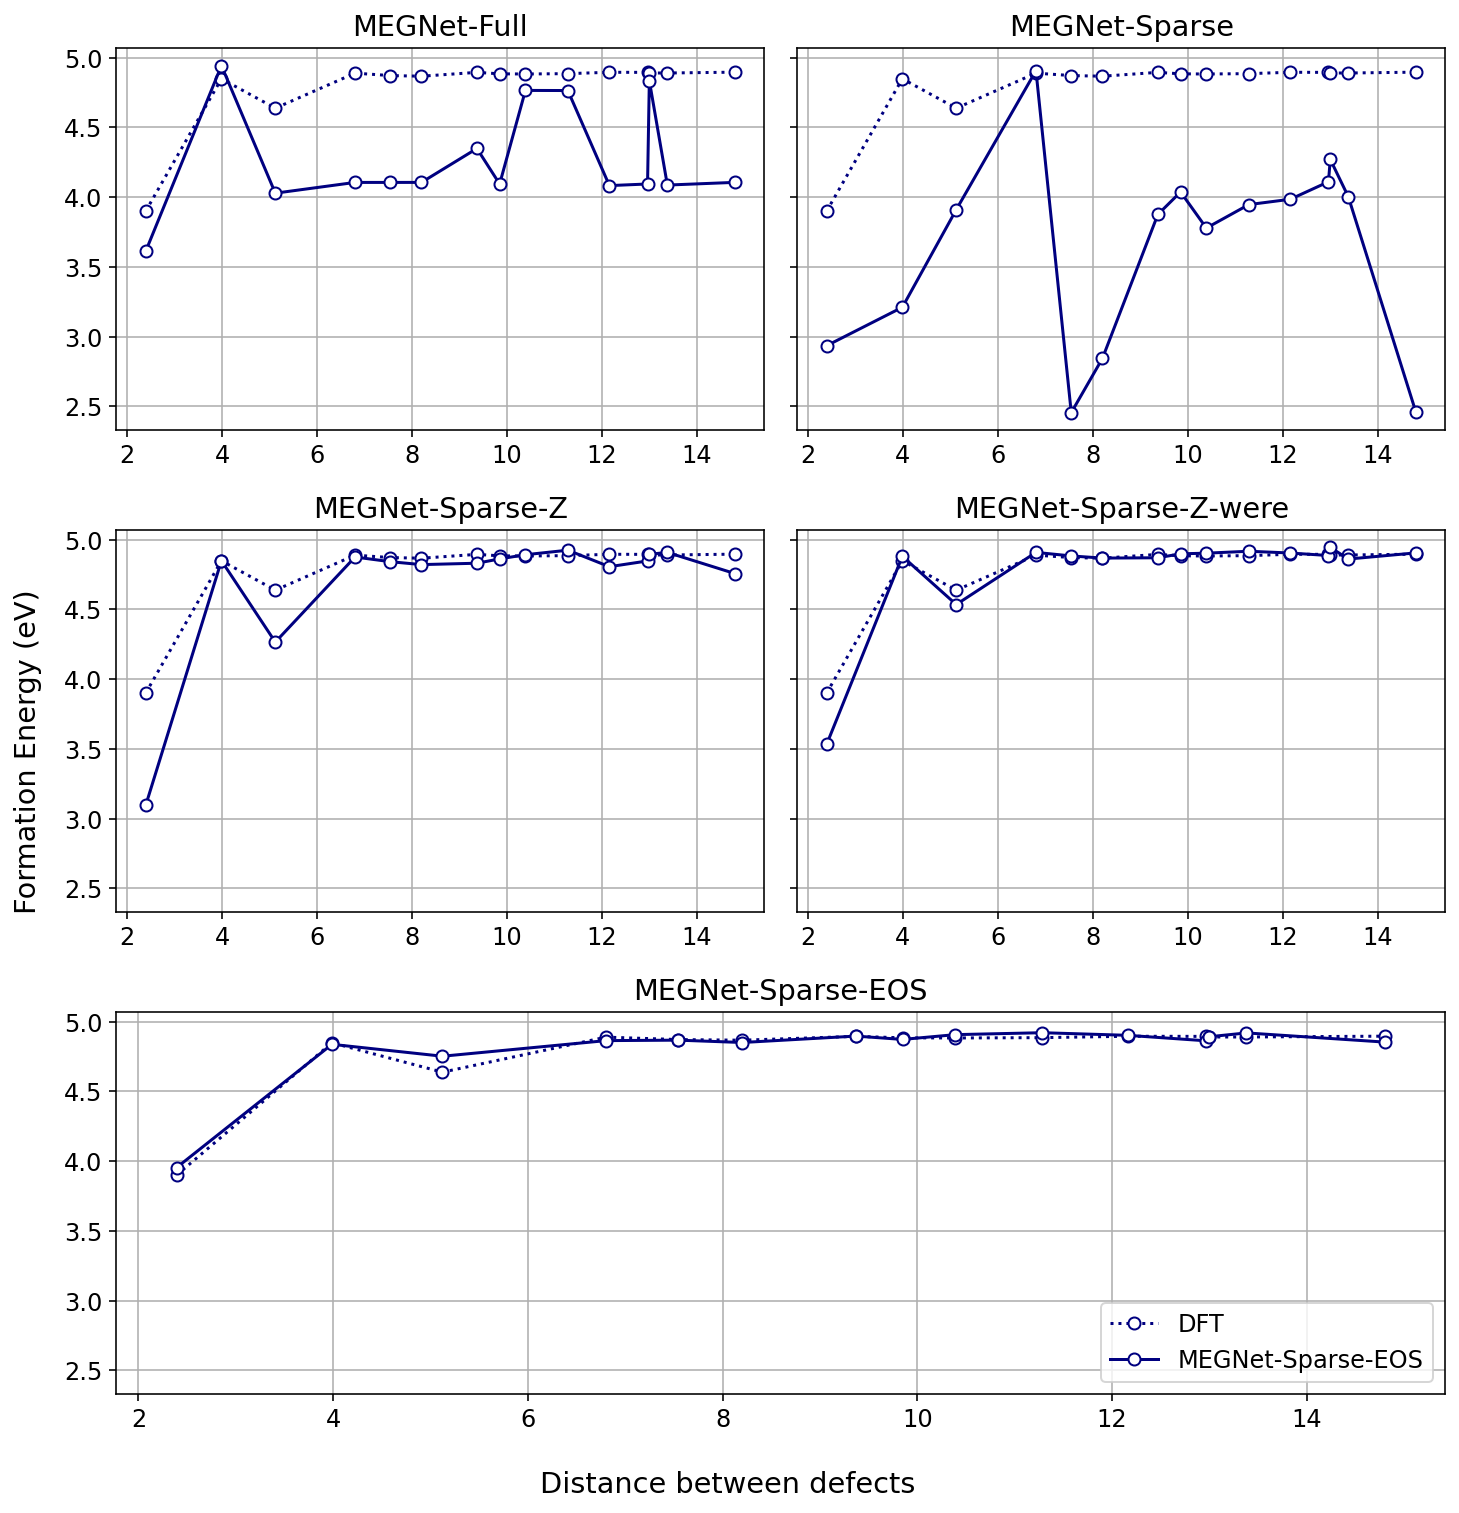

In [210]:
v2_groups, v2_dfs = list(map(list, zip(*predictions.groupby(level=0, axis=1))))
dft = predictions.loc[:, 'DFT'].loc[v2.index].droplevel(1).assign(v2=v2)
# fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True,  constrained_layout=True)

fig, axs = plt.subplot_mosaic([['upper left', 'upper right'],
                                ['middle left', 'middle right'],
                               ['lower', 'lower']],
                              figsize=(10, 10), constrained_layout=True, sharex=False, sharey=True)

for i, (name, ax) in enumerate(zip(['MEGNet-Full', 'MEGNet-Sparse', 'MEGNet-Sparse-Z', 'MEGNet-Sparse-Z-were', 'MEGNet-Sparse-EOS'], axs.values())):
        
    pred = predictions.loc[:, name]
    # pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v2.index].droplevel(1).assign(v2=v2)

    for name, data in {'DFT': dft, name: pred}.items():
        plot(
            data.v2,
            data.formation_energy_per_site / 1000,
            legend=name if i == 4 else "",
            ax=ax,
            color='navy',
            marker= 'o:' if name == 'DFT' else 'o-',
            reset_axis=True if i == 2 else False,
        )
        ax.set_title(name)
ax.legend(loc='lower right')
set_size(8, 8)
fig.supylabel('Formation Energy (eV)'),
fig.supxlabel('Distance between defects')
# fig.suptitle('V2')
fig.tight_layout()


metadata = {
    "Title": "Defects distance V2",
    "Keywords": "2D materials, machine learning, graph neural network, MEGNet"}
try:
    metadata["Author"] = getpass.getuser()
except:
    pass
Path('plots').mkdir(exist_ok=True, parents=True)
filename = Path('plots', f"V2.png")
fig.savefig(filename,
            # bbox_inches='tight',
            # pad_inches=0?.5,
            metadata=metadata,
            dpi=192)
fig.show()


/tmp/ipykernel_238262/3941408062.py:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


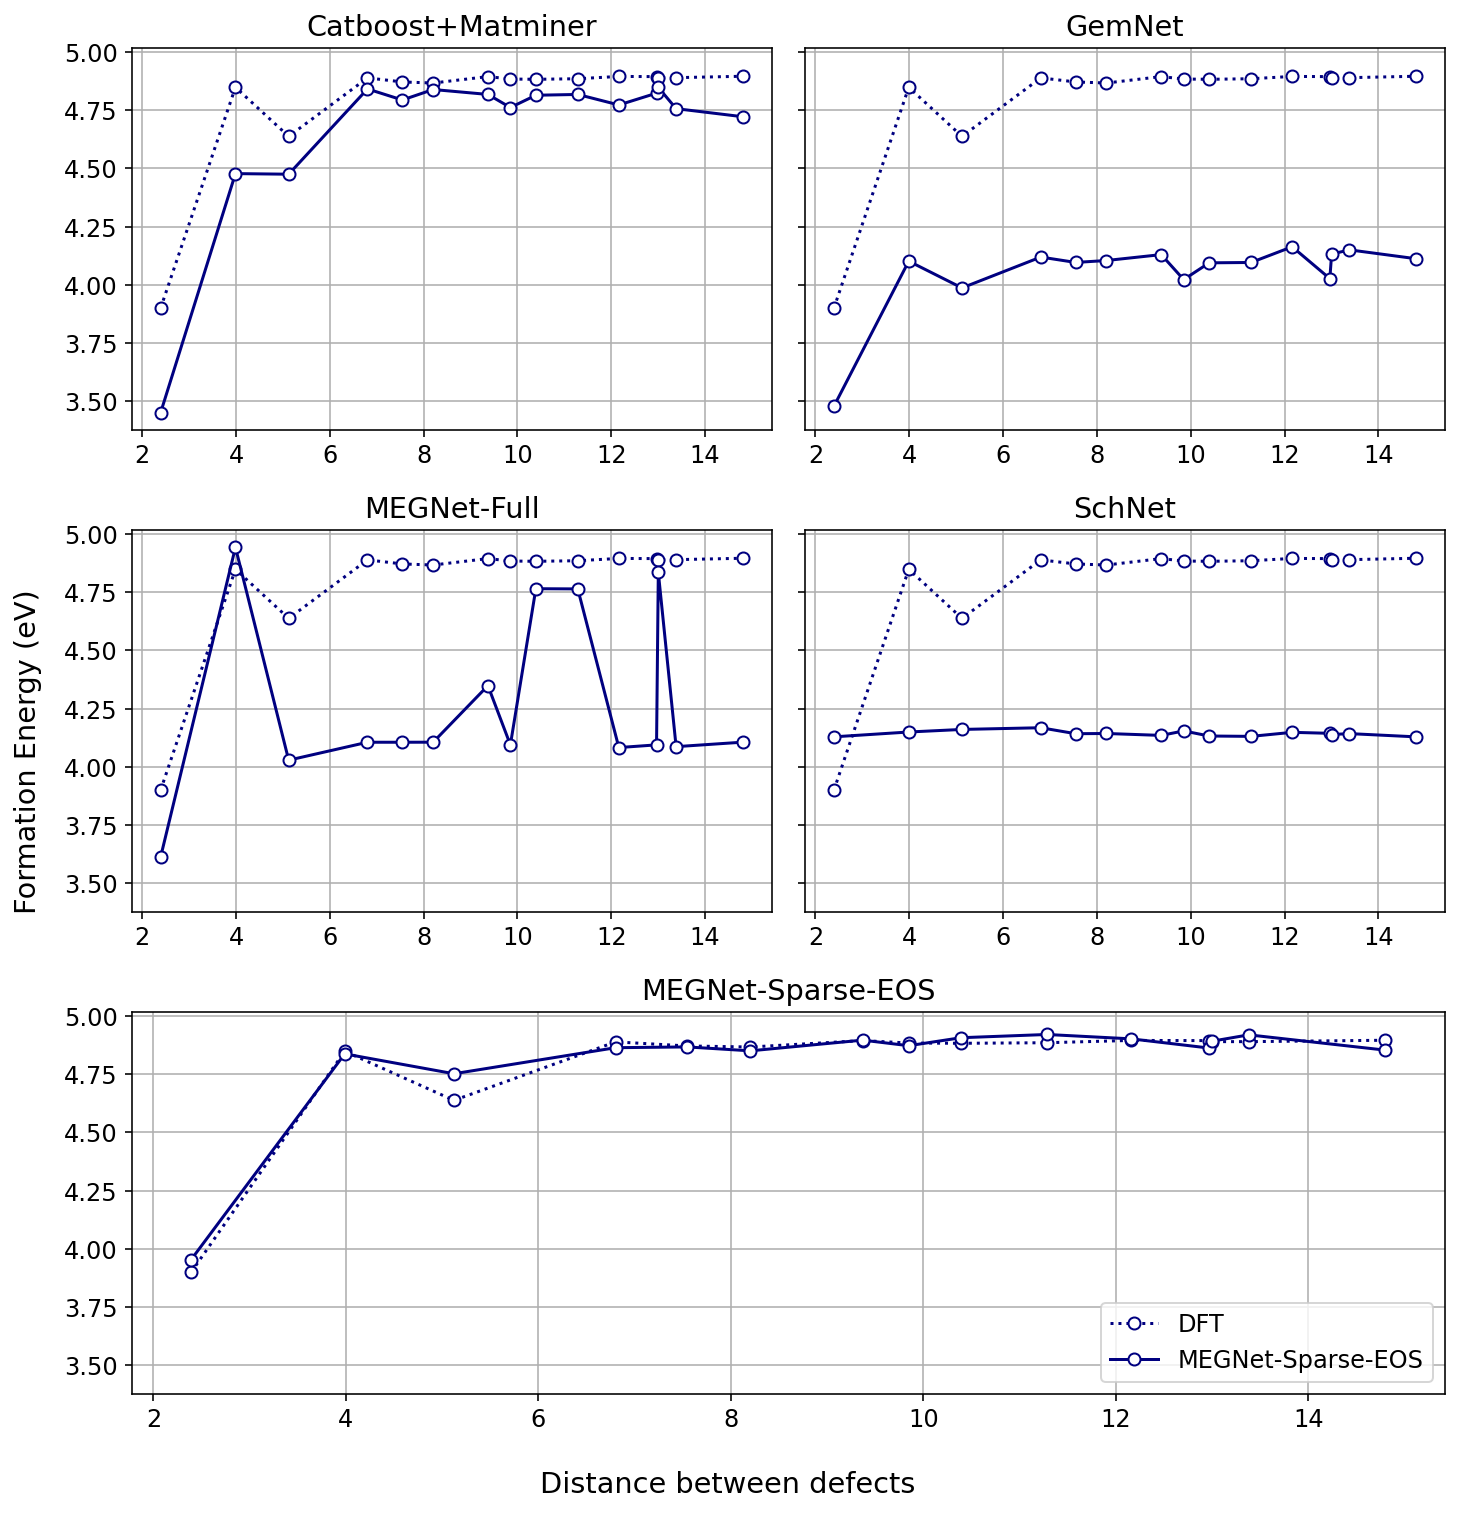

In [219]:
v2_groups, v2_dfs = list(map(list, zip(*predictions.groupby(level=0, axis=1))))
dft = predictions.loc[:, 'DFT'].loc[v2.index].droplevel(1).assign(v2=v2)
# fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True,  constrained_layout=True)

fig, axs = plt.subplot_mosaic([['upper left', 'upper right'],
                                ['middle left', 'middle right'],
                               ['lower', 'lower']],
                              figsize=(10, 10), constrained_layout=True, sharex=False, sharey=True)

for i, (name, ax) in enumerate(zip(['Catboost+Matminer', 'GemNet', 'MEGNet-Full', 'SchNet', 'MEGNet-Sparse-EOS'], axs.values())):
        
    pred = predictions.loc[:, name]
    # pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v2.index].droplevel(1).assign(v2=v2)

    for name, data in {'DFT': dft, name: pred}.items():
        plot(
            data.v2,
            data.formation_energy_per_site / 1000,
            legend=name if i == 4 else "",
            ax=ax,
            color='navy',
            marker= 'o:' if name == 'DFT' else 'o-',
            reset_axis=True if i == 2 else False,
        )
        ax.set_title(name)
ax.legend(loc='lower right')
set_size(8, 8)
fig.supylabel('Formation Energy (eV)'),
fig.supxlabel('Distance between defects')
# fig.suptitle('V2')
fig.tight_layout()


metadata = {
    "Title": "Defects distance V2",
    "Keywords": "2D materials, machine learning, graph neural network, MEGNet"}
try:
    metadata["Author"] = getpass.getuser()
except:
    pass
Path('plots').mkdir(exist_ok=True, parents=True)
filename = Path('plots', f"V2_baselines.png")
fig.savefig(filename,
            # bbox_inches='tight',
            # pad_inches=0?.5,
            metadata=metadata,
            dpi=192)
fig.show()


In [217]:
set(predictions.columns.get_level_values(0))

{'Catboost+Matminer',
 'DFT',
 'GemNet',
 'MEGNet-Full',
 'MEGNet-Full-EOS',
 'MEGNet-Full-Z',
 'MEGNet-Sparse',
 'MEGNet-Sparse-EOS',
 'MEGNet-Sparse-Z',
 'MEGNet-Sparse-Z-were',
 'SchNet'}

/tmp/ipykernel_238262/2421424887.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


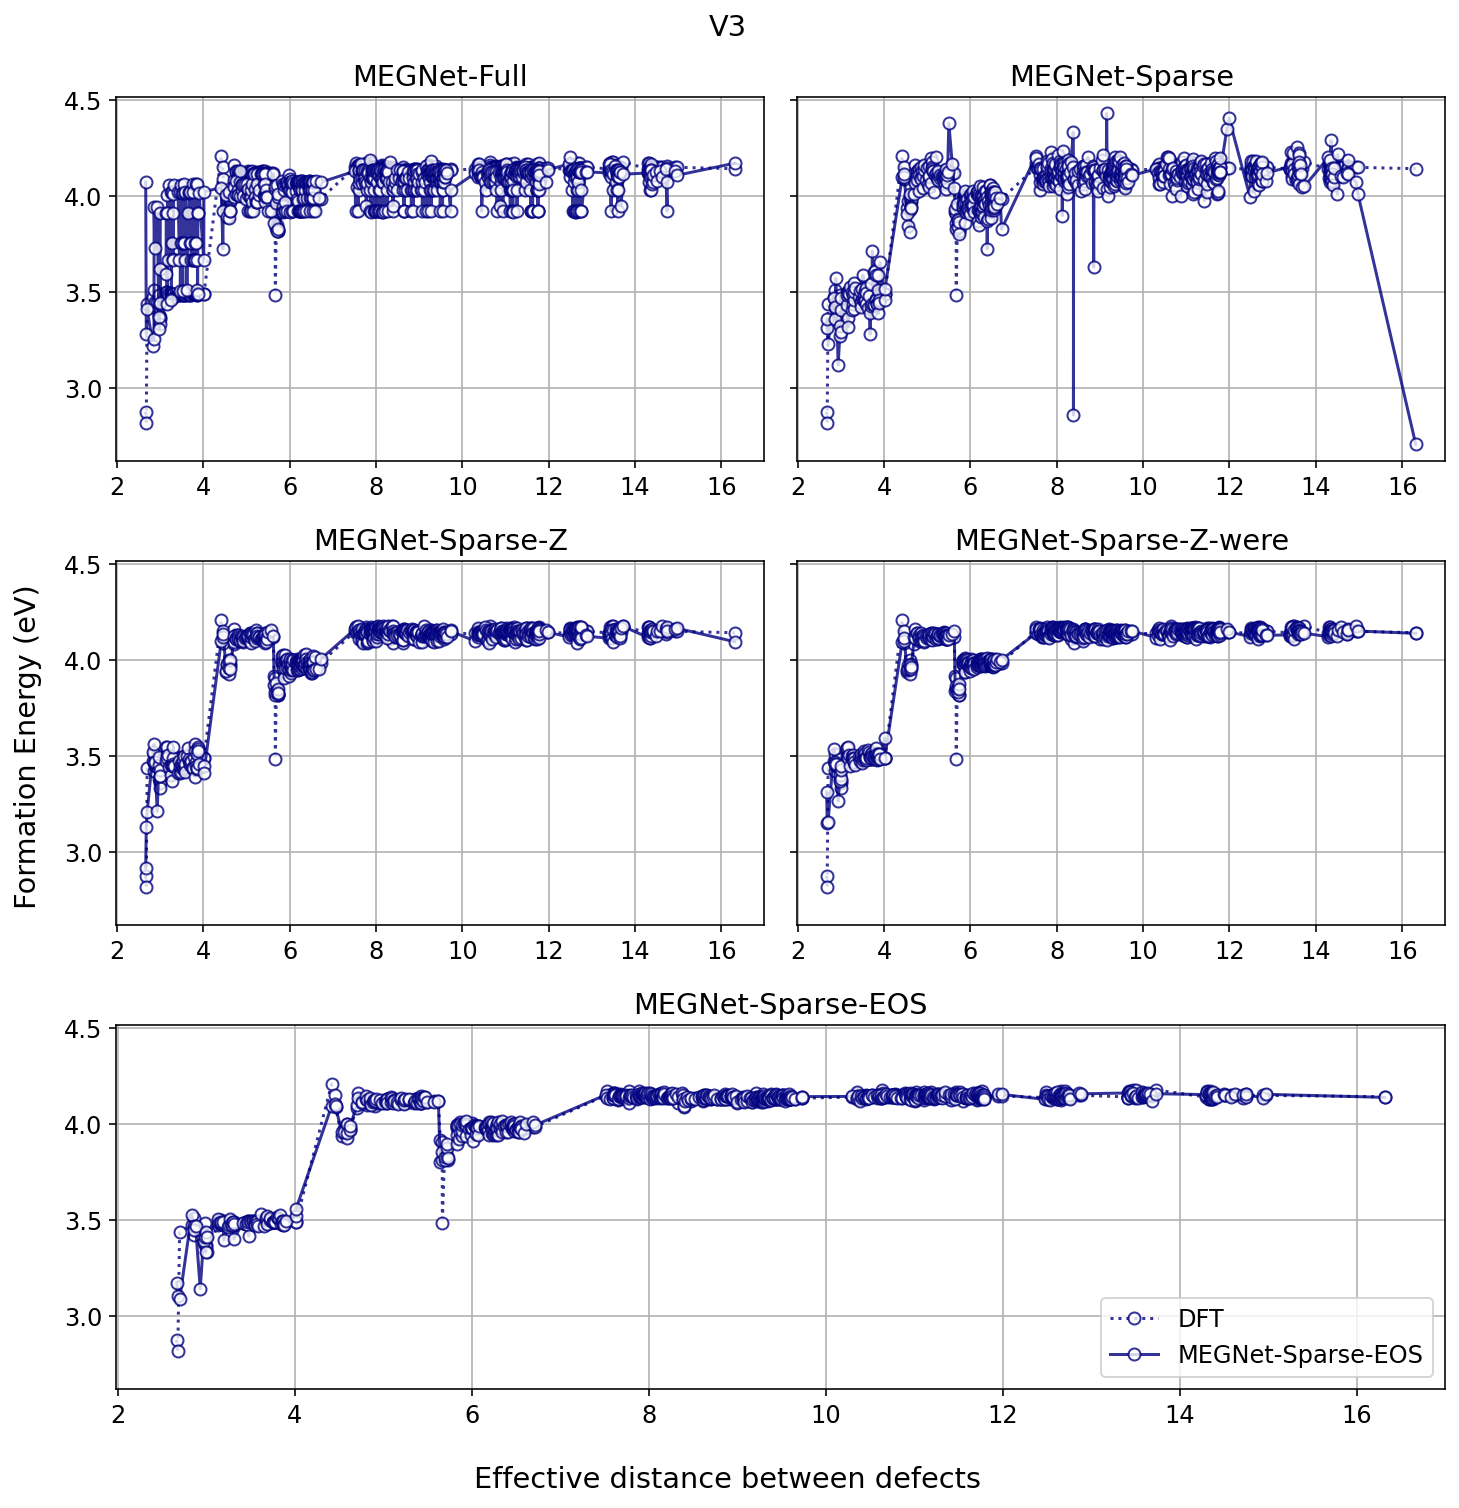

In [204]:
v3_groups, v3_dfs = list(map(list, zip(*predictions.groupby(level=0, axis=1))))
dft = predictions.loc[:, 'DFT'].loc[v3.index].droplevel(1).assign(v3=v3)

fig, axs = plt.subplot_mosaic([['upper left', 'upper right'],
                                ['middle left', 'middle right'],
                               ['lower', 'lower']],
                              figsize=(10, 10), constrained_layout=True, sharex=False, sharey=True)

for i, (name, ax) in enumerate(zip(['MEGNet-Full', 'MEGNet-Sparse', 'MEGNet-Sparse-Z', 'MEGNet-Sparse-Z-were', 'MEGNet-Sparse-EOS'], axs.values())):
        
    pred = predictions.loc[:, name]
    # pred = pred.droplevel(0, axis=1)
    pred = pred.loc[v3.index].droplevel(1).assign(v3=v3)
    for name, data in {'DFT': dft, name: pred}.items():
        plot(
            data.v3,
            data.formation_energy_per_site / 1000,
            legend=name if i == 4 else "",
            ax=ax,
            color='navy',
            alpha=0.8,
            marker= 'o:' if name == 'DFT' else 'o-',
            reset_axis=True if i == 2 else False,
        )
        ax.set_title(name)
ax.legend(loc='lower right')
set_size(8, 8)
fig.supylabel('Formation Energy (eV)'),
fig.supxlabel('Effective distance between defects')
fig.suptitle('V3')
fig.tight_layout()


metadata = {
    "Title": "Defects distance V3",
    "Keywords": "2D materials, machine learning, graph neural network, MEGNet"}
try:
    metadata["Author"] = getpass.getuser()
except:
    pass
Path('plots').mkdir(exist_ok=True, parents=True)
filename = Path('plots', f"V3.png")
fig.savefig(filename,
            # bbox_inches='tight',
            # pad_inches=0?.5,
            metadata=metadata,
            dpi=192)
fig.show()


### Plots

In [205]:


def plot(predictions, true_targets, experiment_name, plots_folder=Path('./plots')):
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True) #gridspec_kw={'wspace':0.3, 'hspace':0.3})
    axs = axs.flatten()
    for i, (_energy_name, _) in enumerate(predictions.groupby(level=0, axis=1)):
        if _energy_name == 'normalized_homo' or _energy_name == 'normalized_lumo': continue
        mae = np.abs(predictions[_energy_name] - true_targets[_energy_name]).mean()

        target_name=target_name_pretty_mapper.get(_energy_name)
        axs[i].scatter(true_targets[_energy_name],
                    predictions[_energy_name],
                    s=40,
                    facecolors='none',
                    edgecolors='navy',
                    label=f"$\mathrm{{MAE}}={mae:.4f}$",
                    alpha=0.3)
   
        axs[i].set_title(f'{target_name} (eV)')
        axs[i].legend()

        lims = [
            np.min([axs[i].get_xlim(), axs[i].get_ylim()]),
            np.max([axs[i].get_xlim(), axs[i].get_ylim()]),
        ]
        axs[i].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        axs[i].set_aspect('equal')
        axs[i].set_xlim(lims)
        axs[i].set_ylim(lims)
        axs[i].margins(x=0, y=0)

    set_size(8, 8)
    fig.suptitle(experiment_name)
    fig.supxlabel(f"DFT")
    fig.supylabel(f"Predicted")

    metadata = {
        "Title": f"Predictions for {target_name} "
                    f"for experiment {experiment_name}",
        "Keywords": "2D materials, machine learning, graph neural network, MEGNet"}
    try:
        metadata["Author"] = getpass.getuser()
    except:
        pass
    plots_folder.mkdir(exist_ok=True, parents=True)
    filename = Path(plots_folder, f"{experiment_name}.png")
    # plt.axis('square')
    fig.savefig(filename,
                # bbox_inches='tight',
                # pad_inches=0?.5,
                metadata=metadata,
                dpi=192)
    fig.show()
    return filename

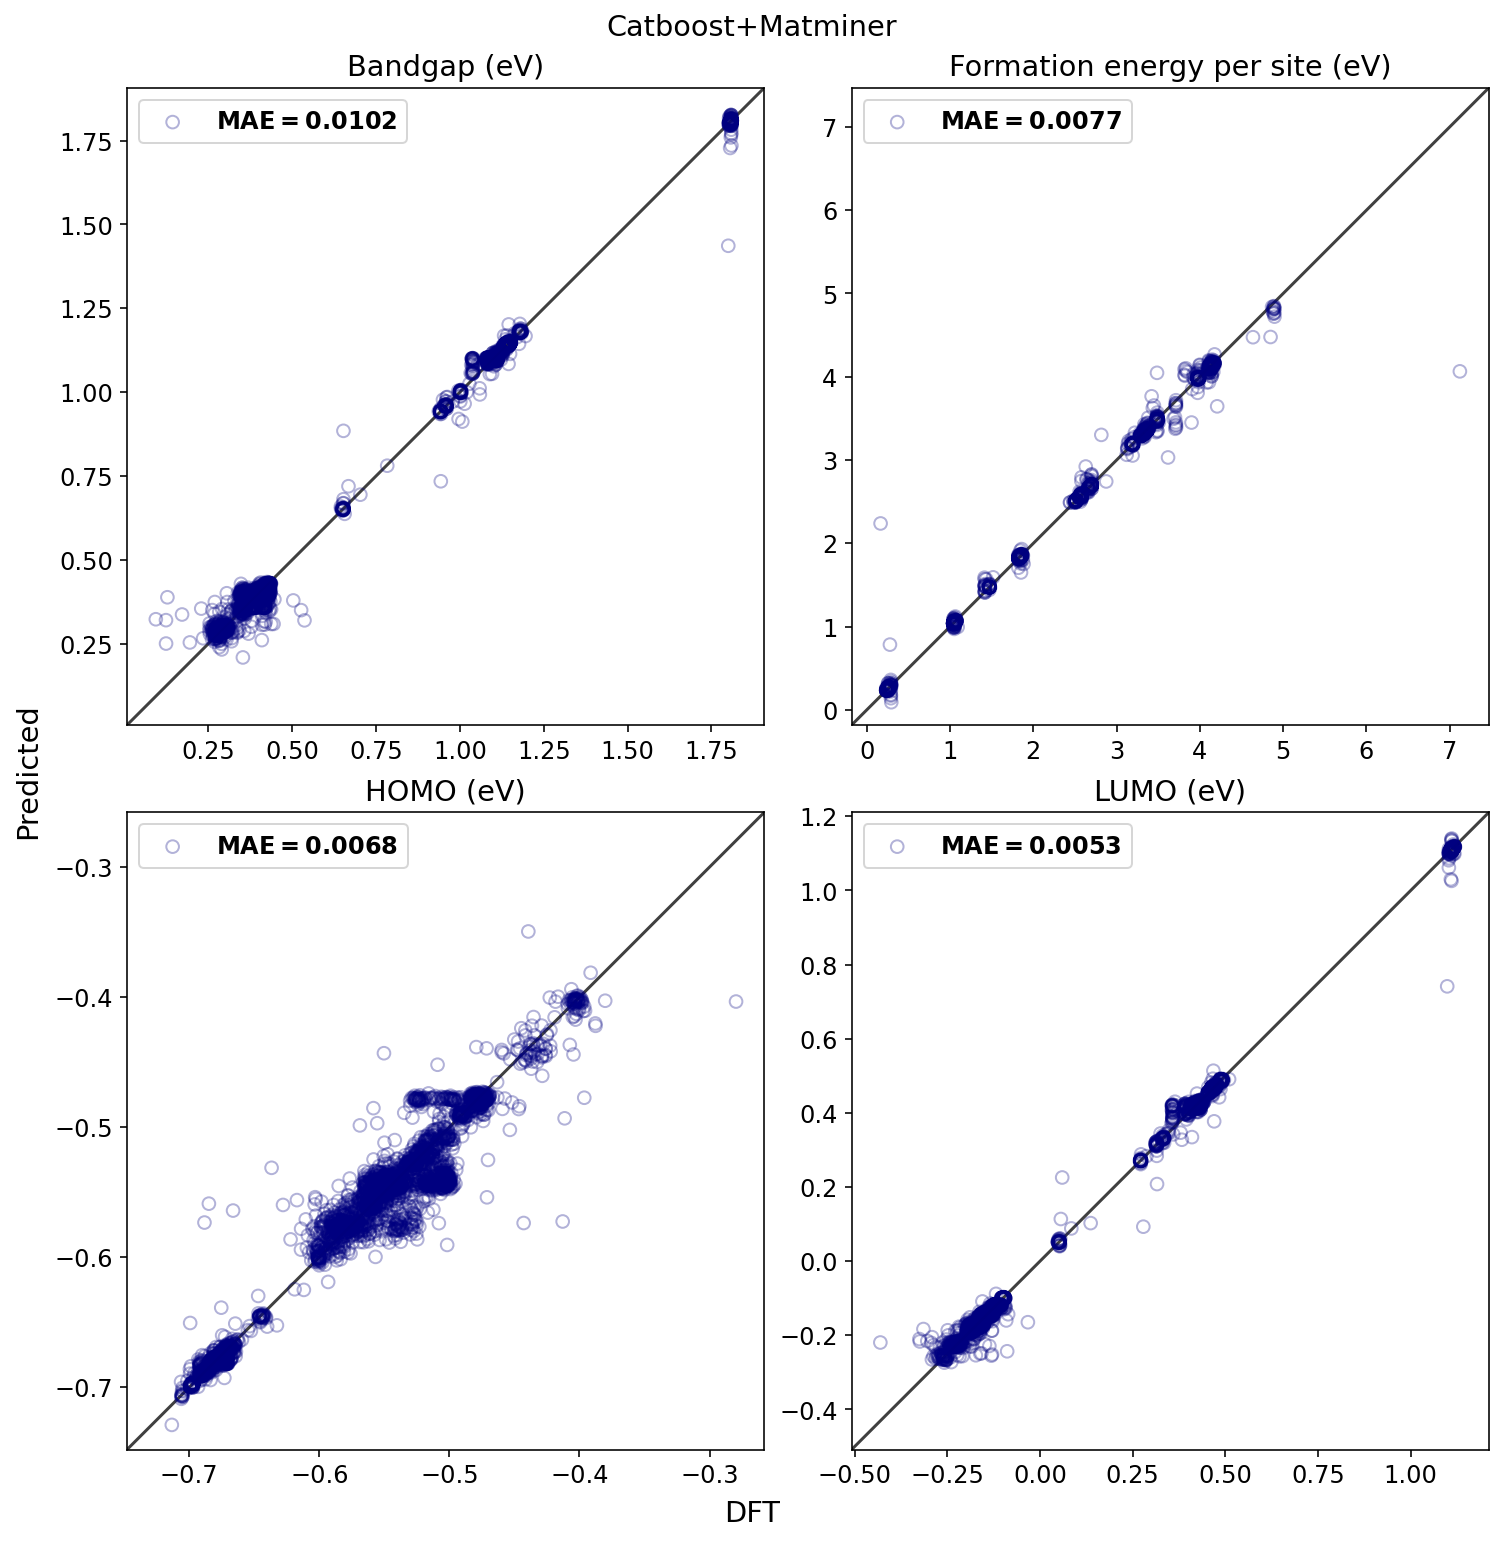

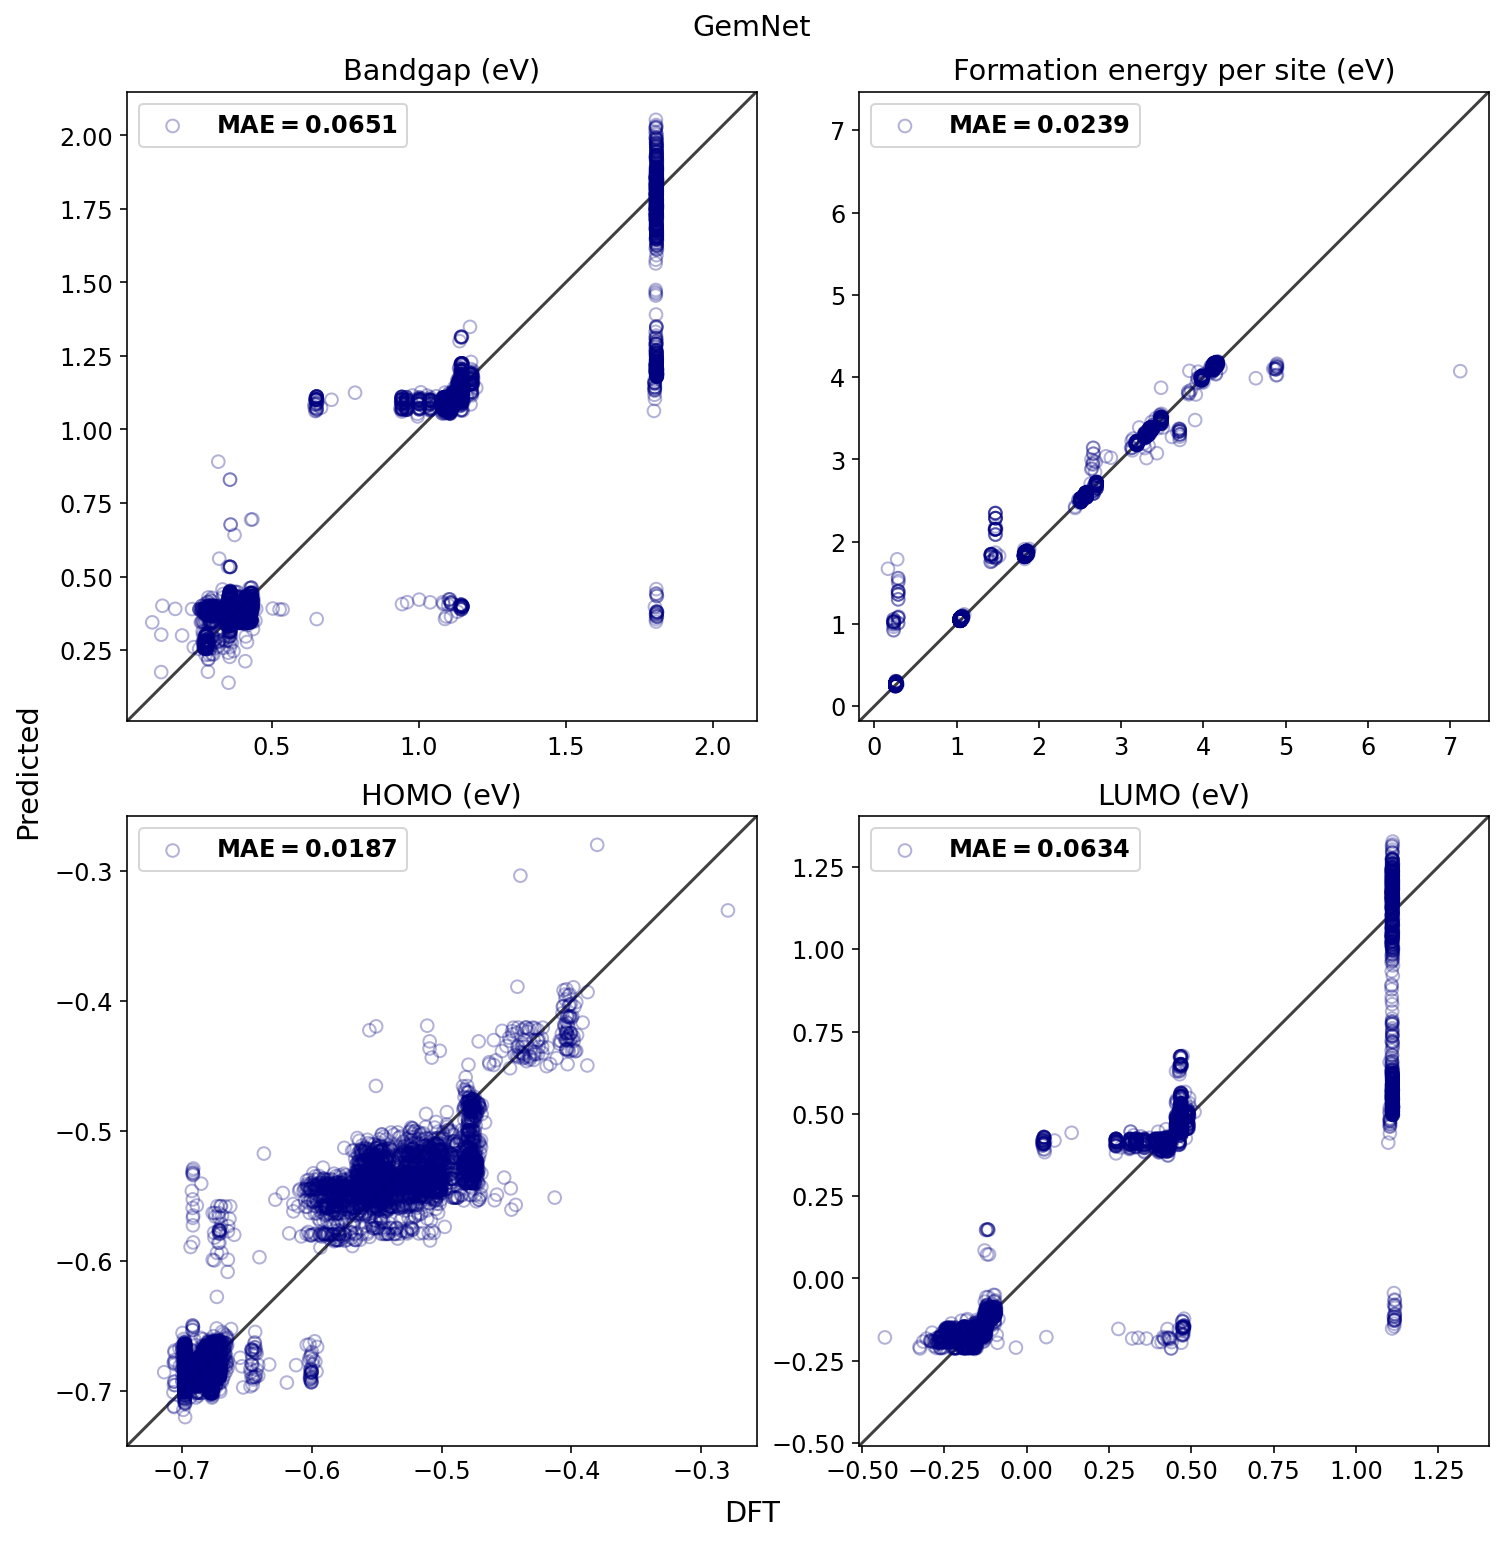

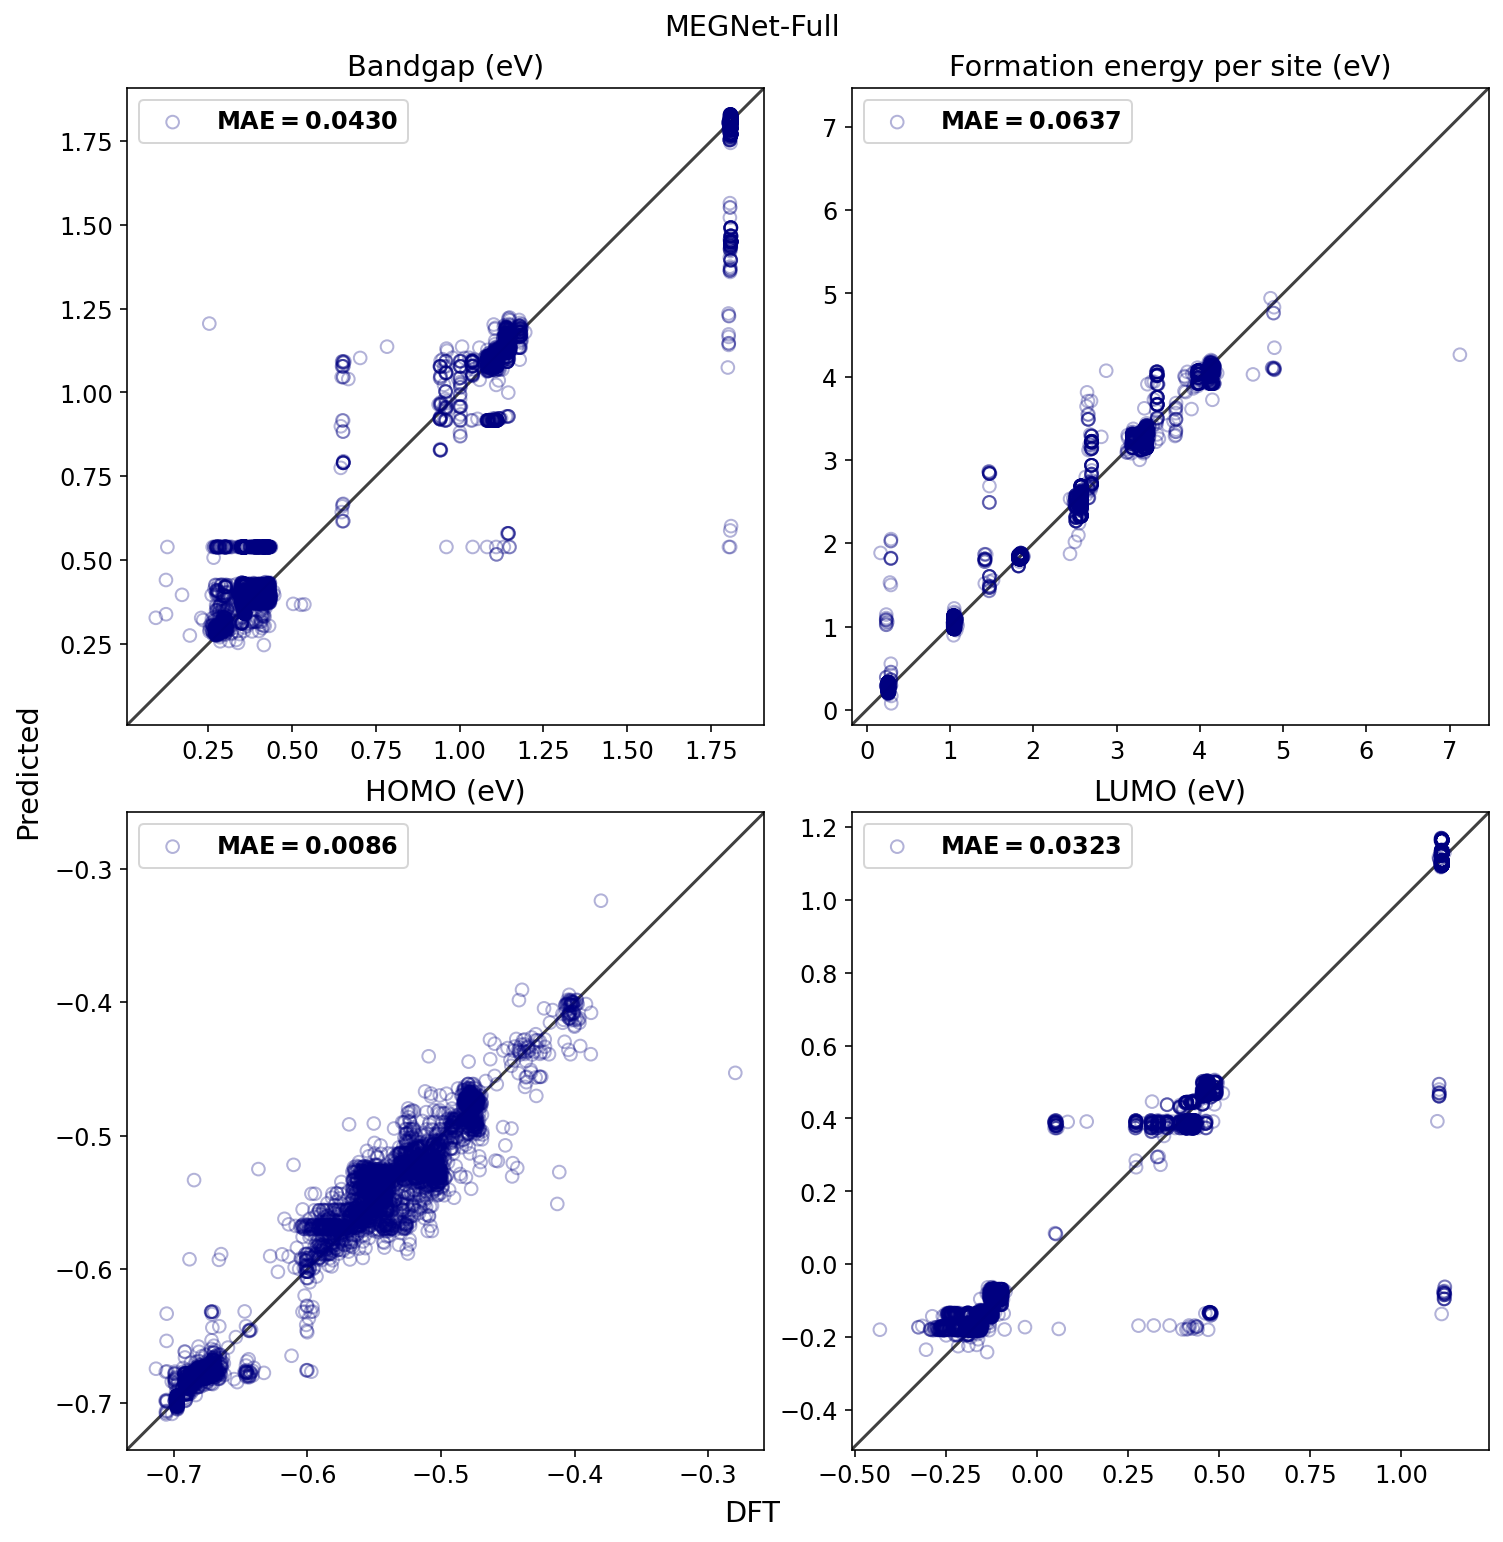

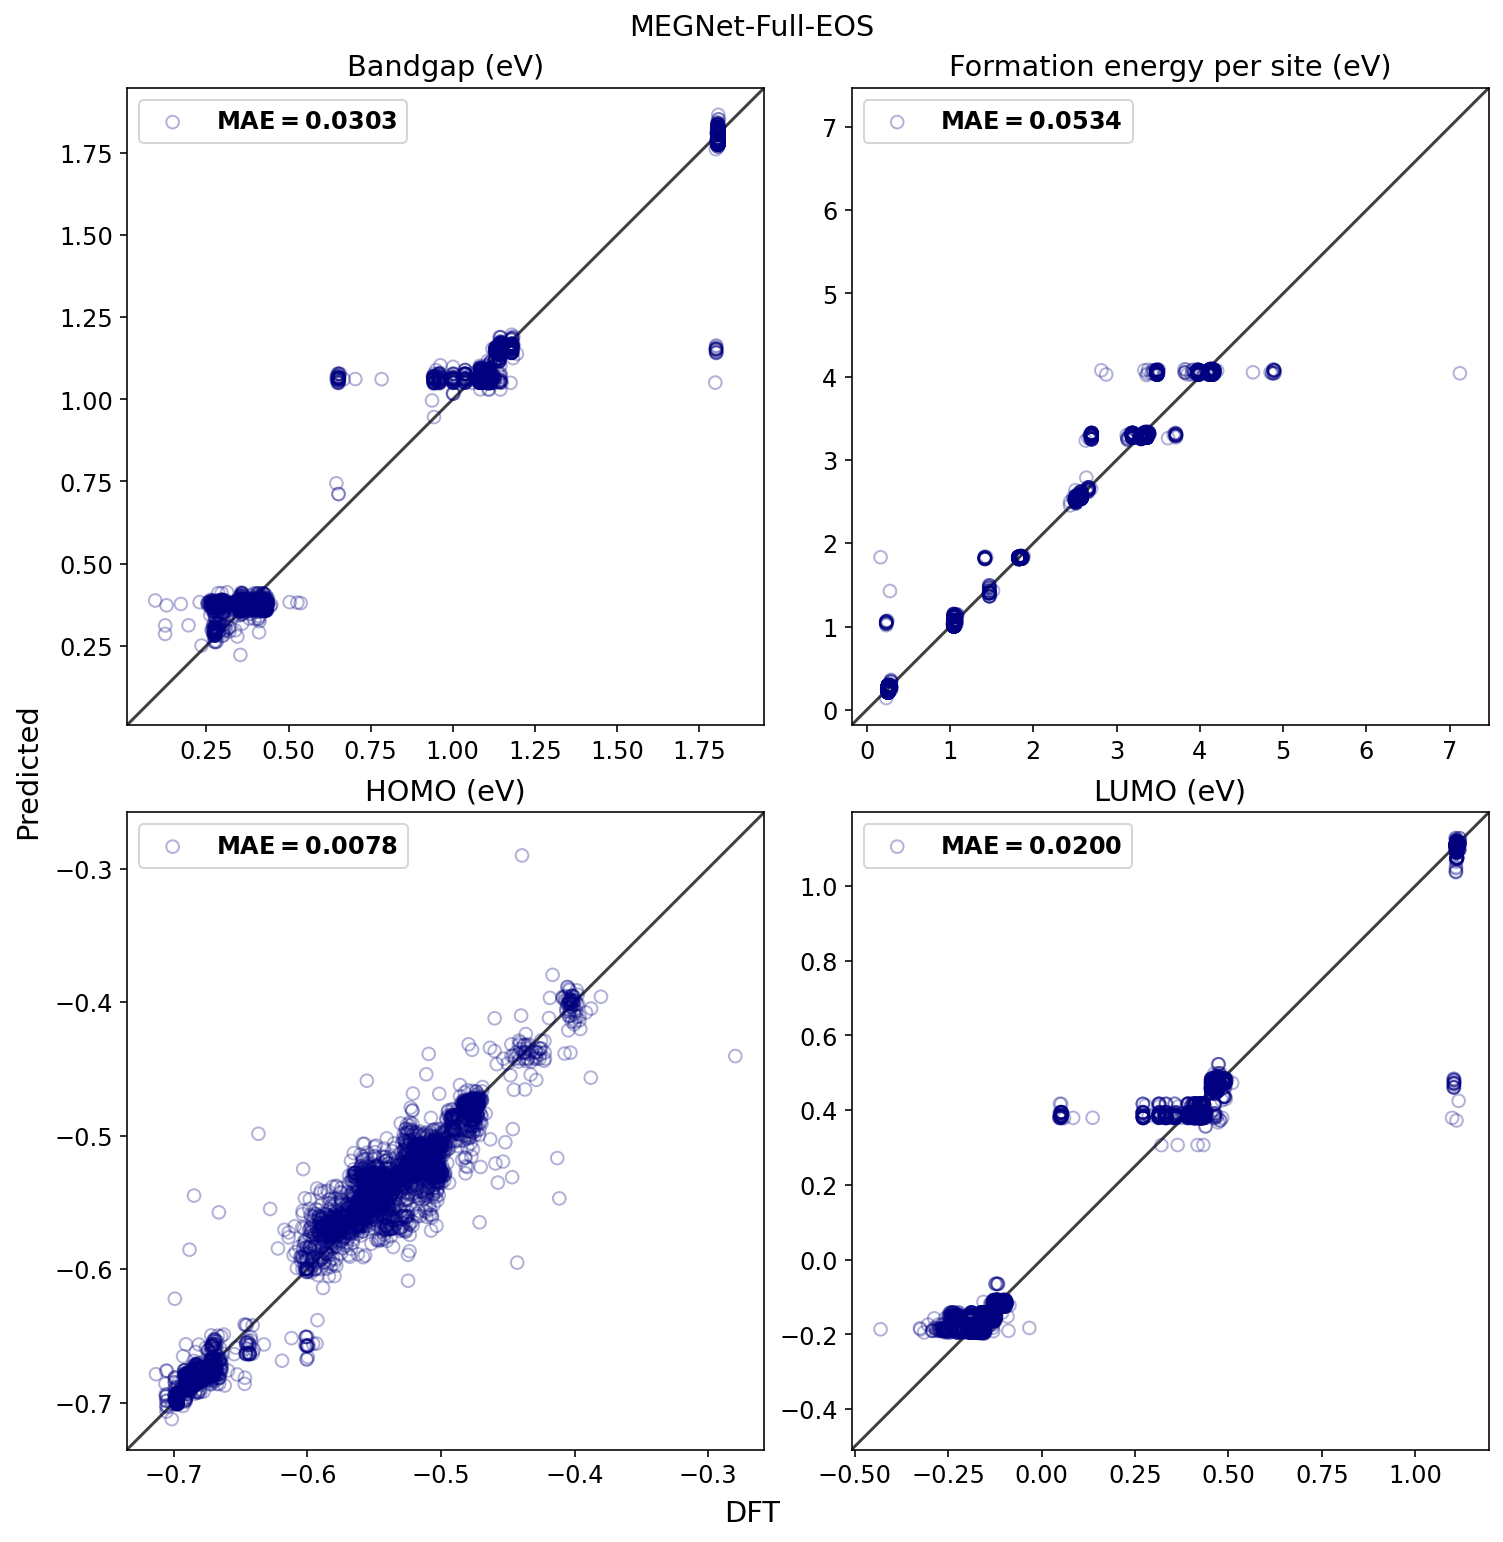

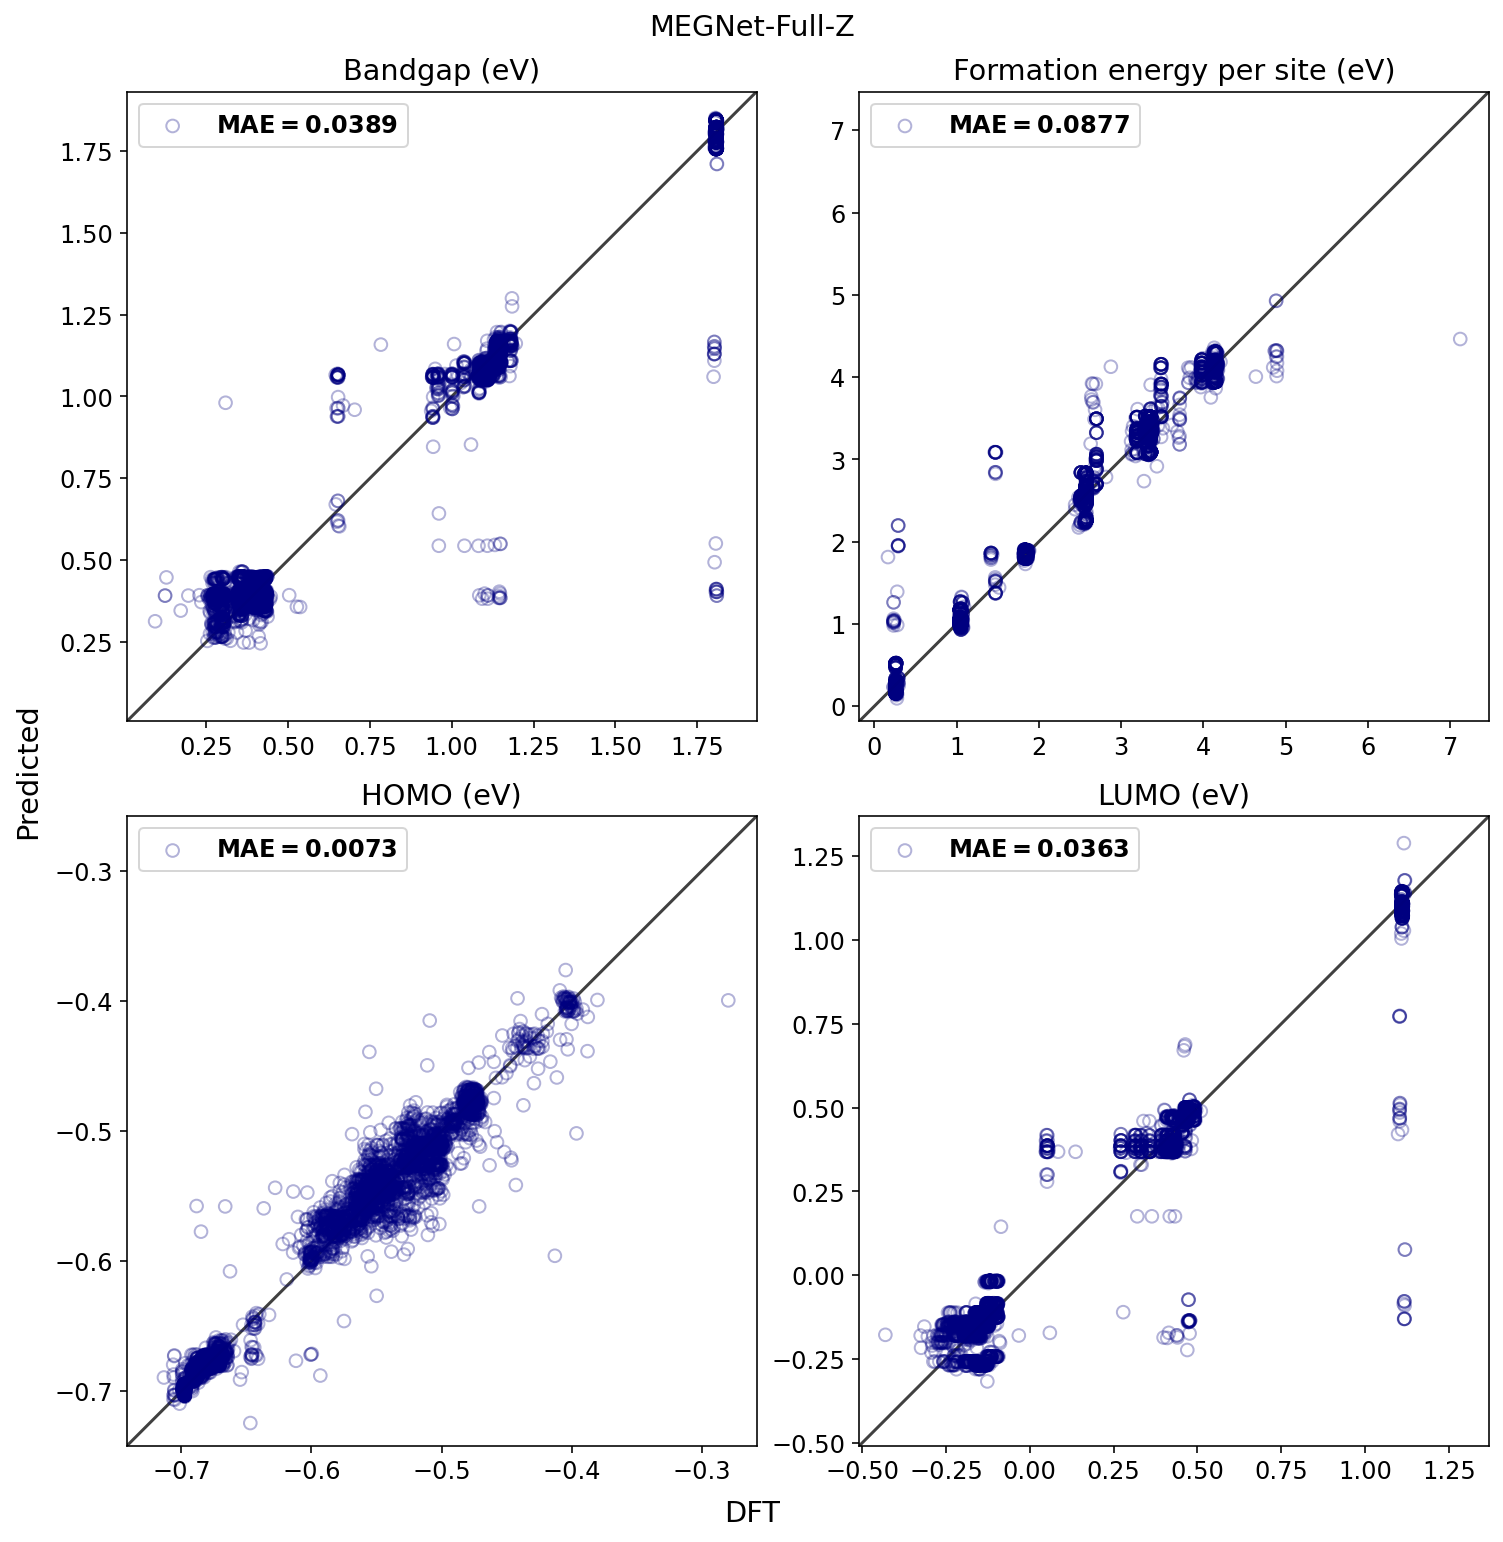

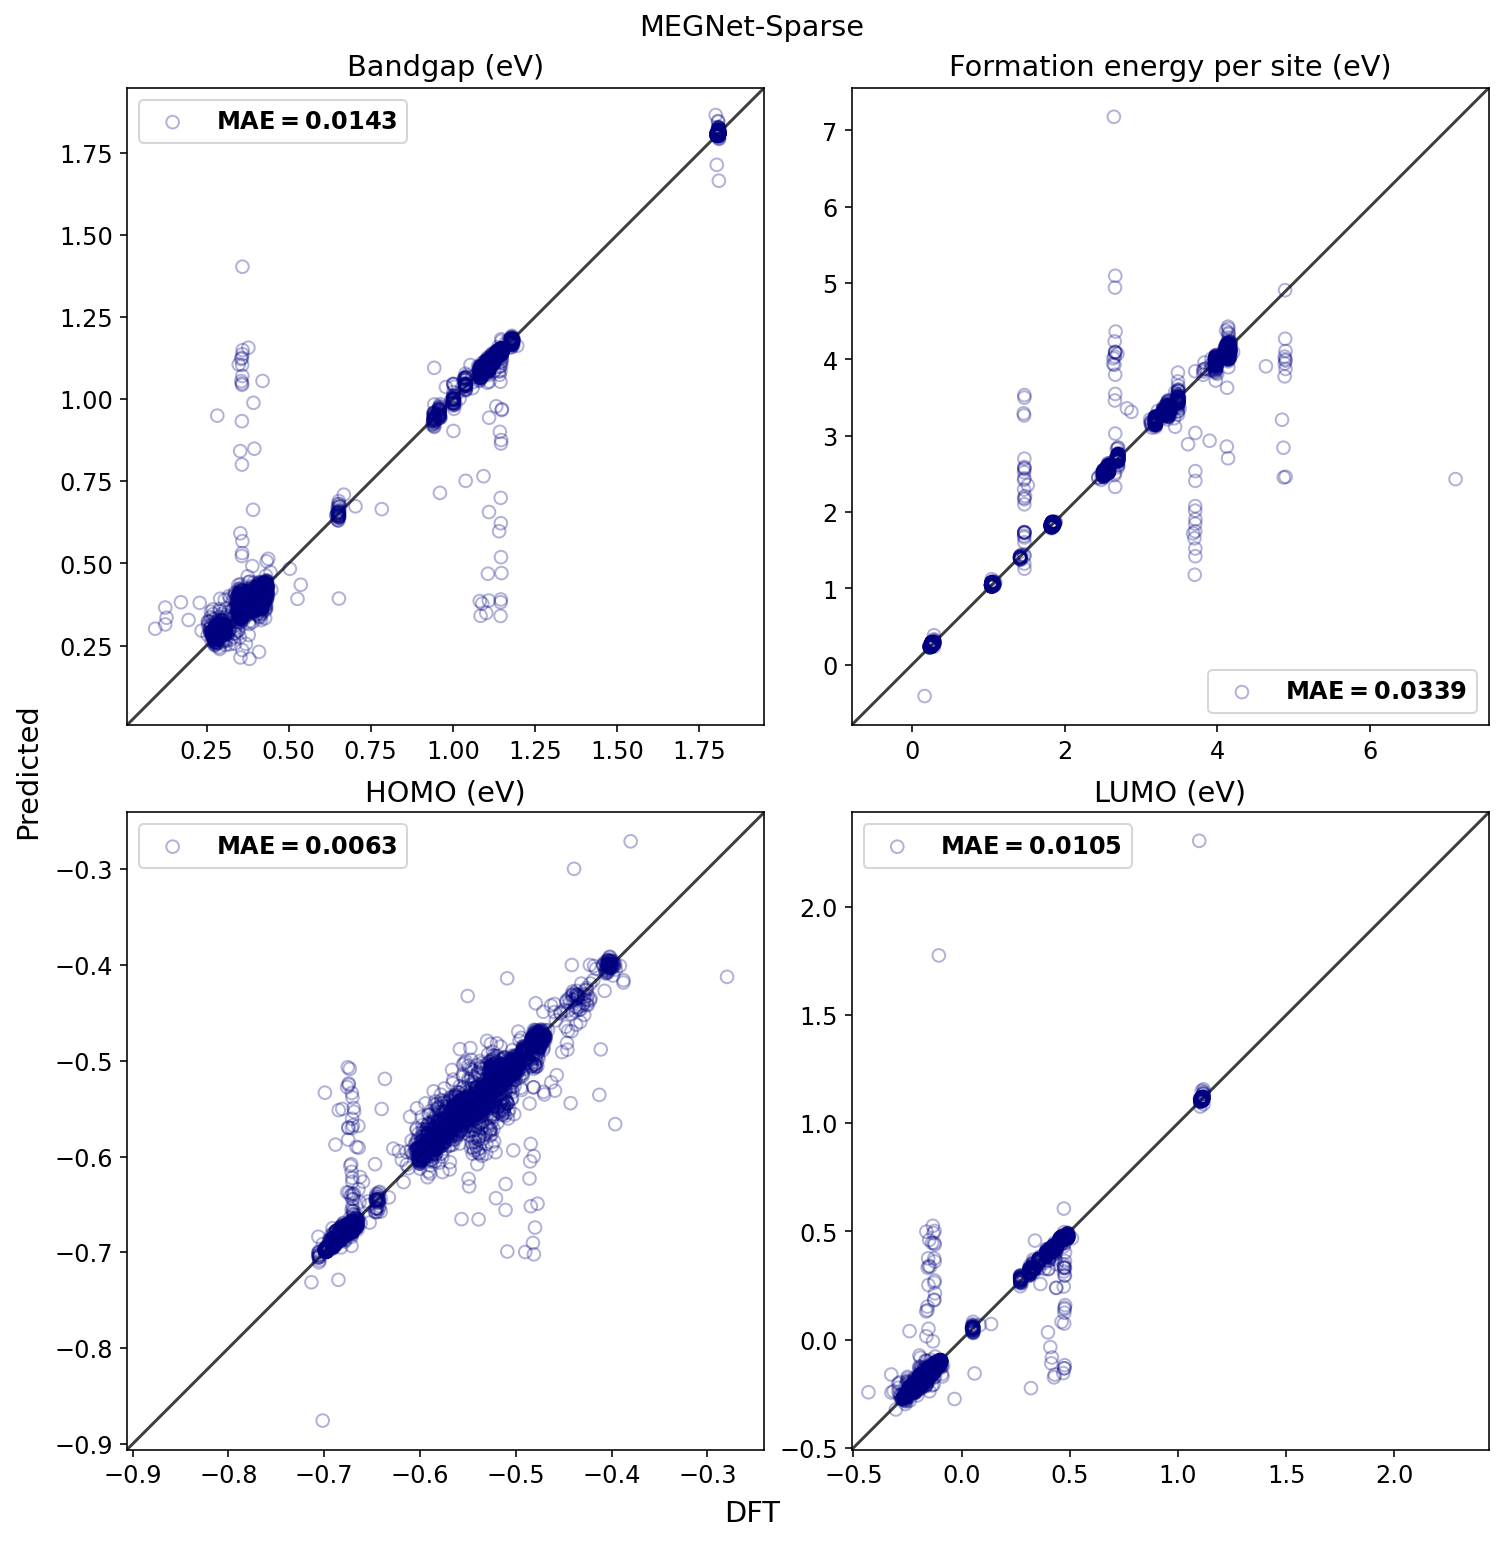

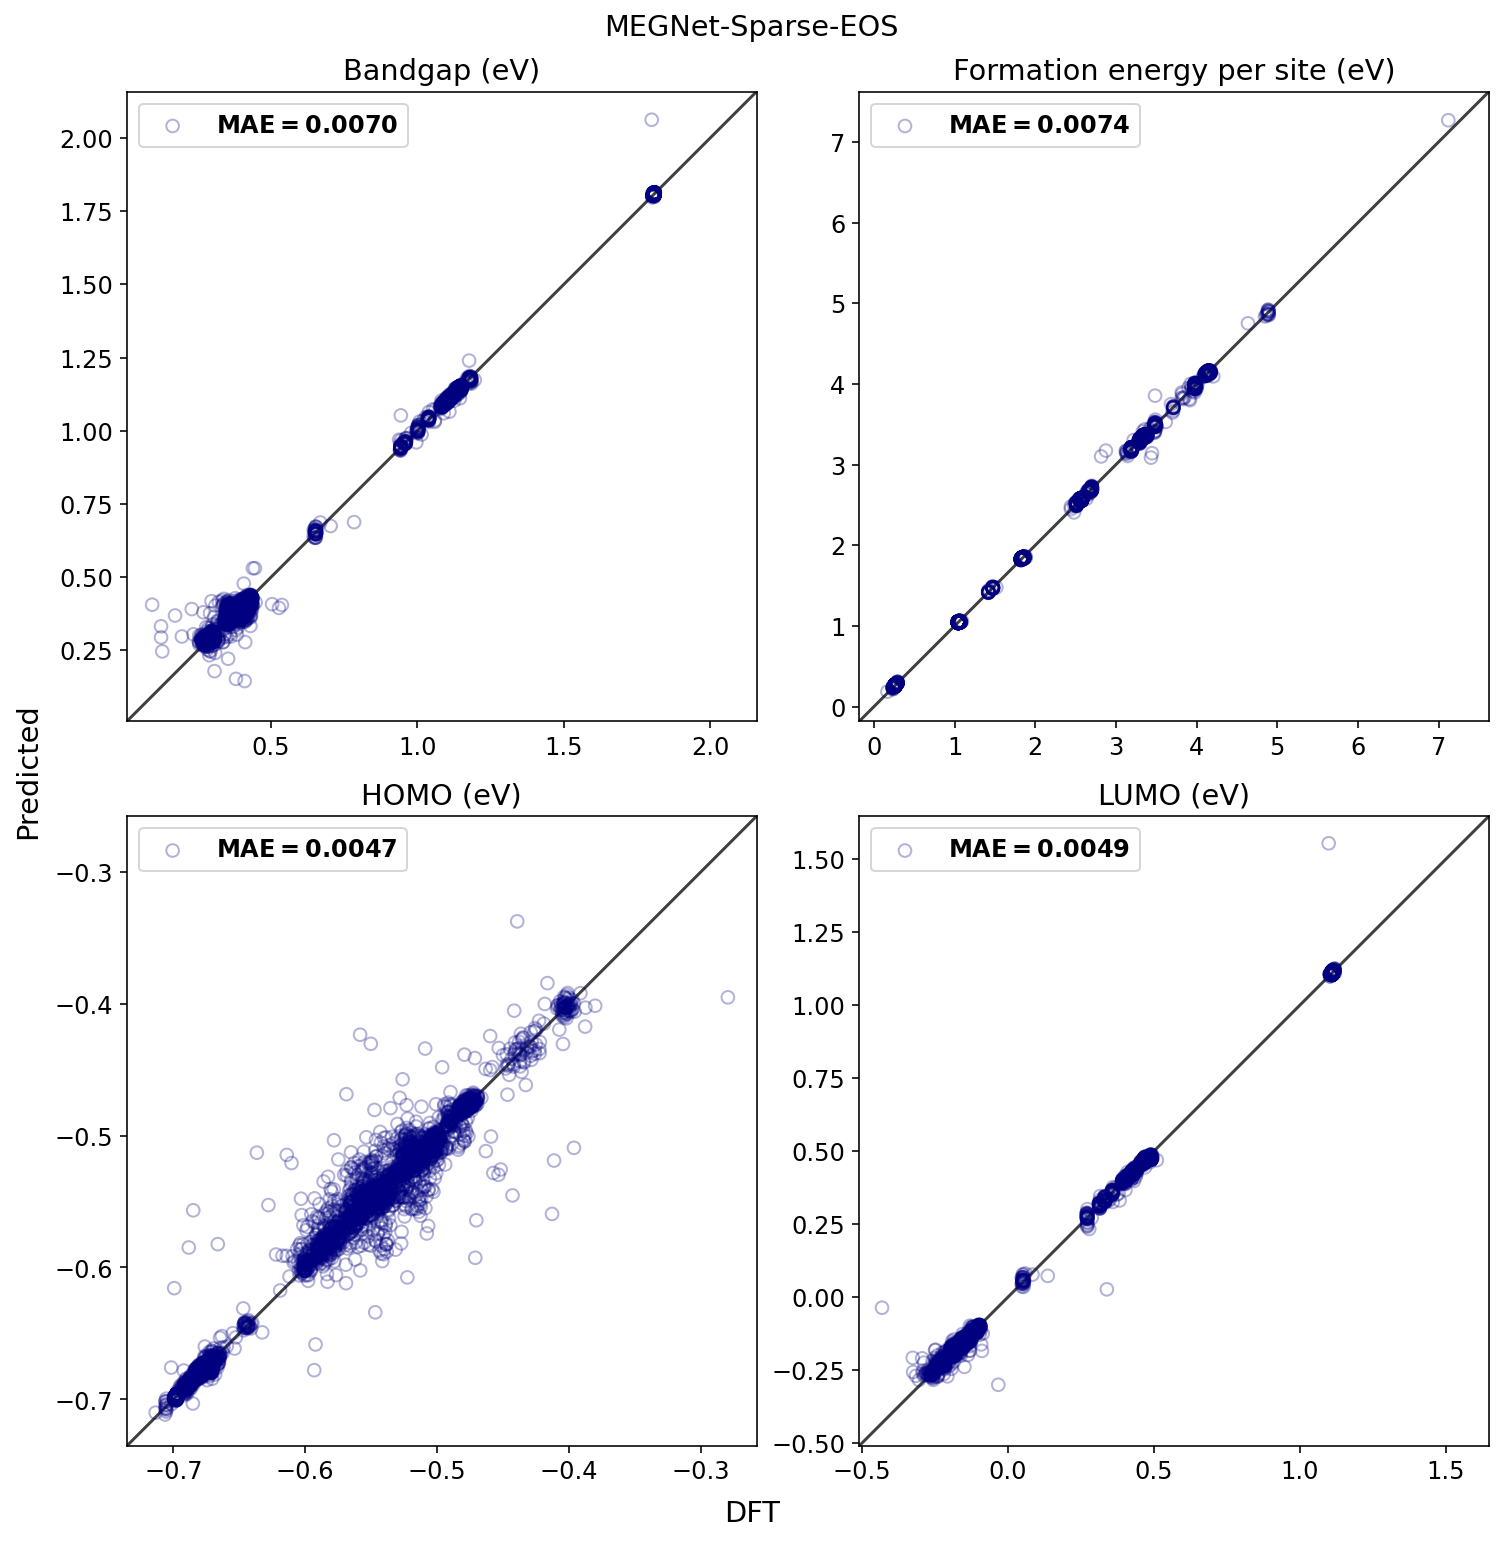

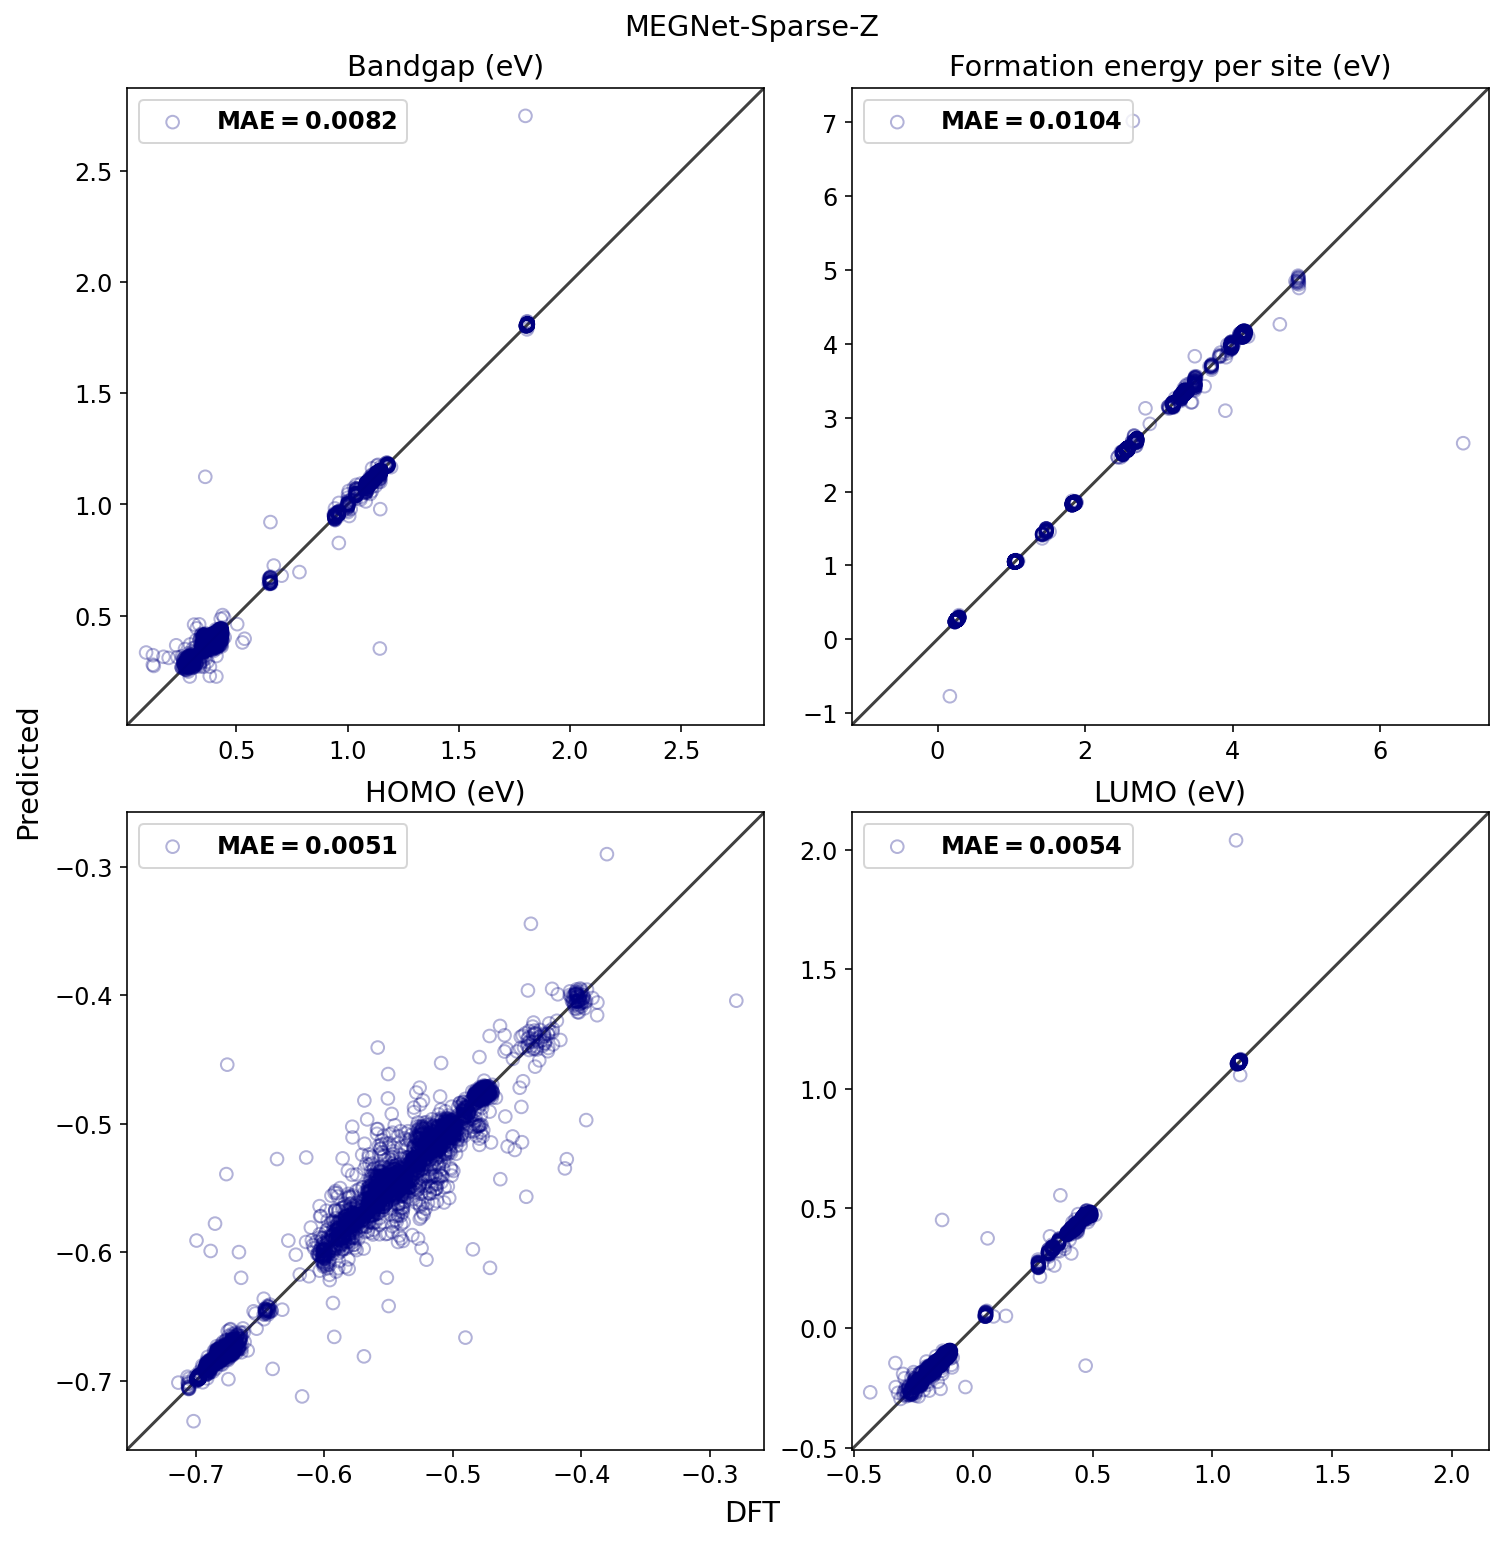

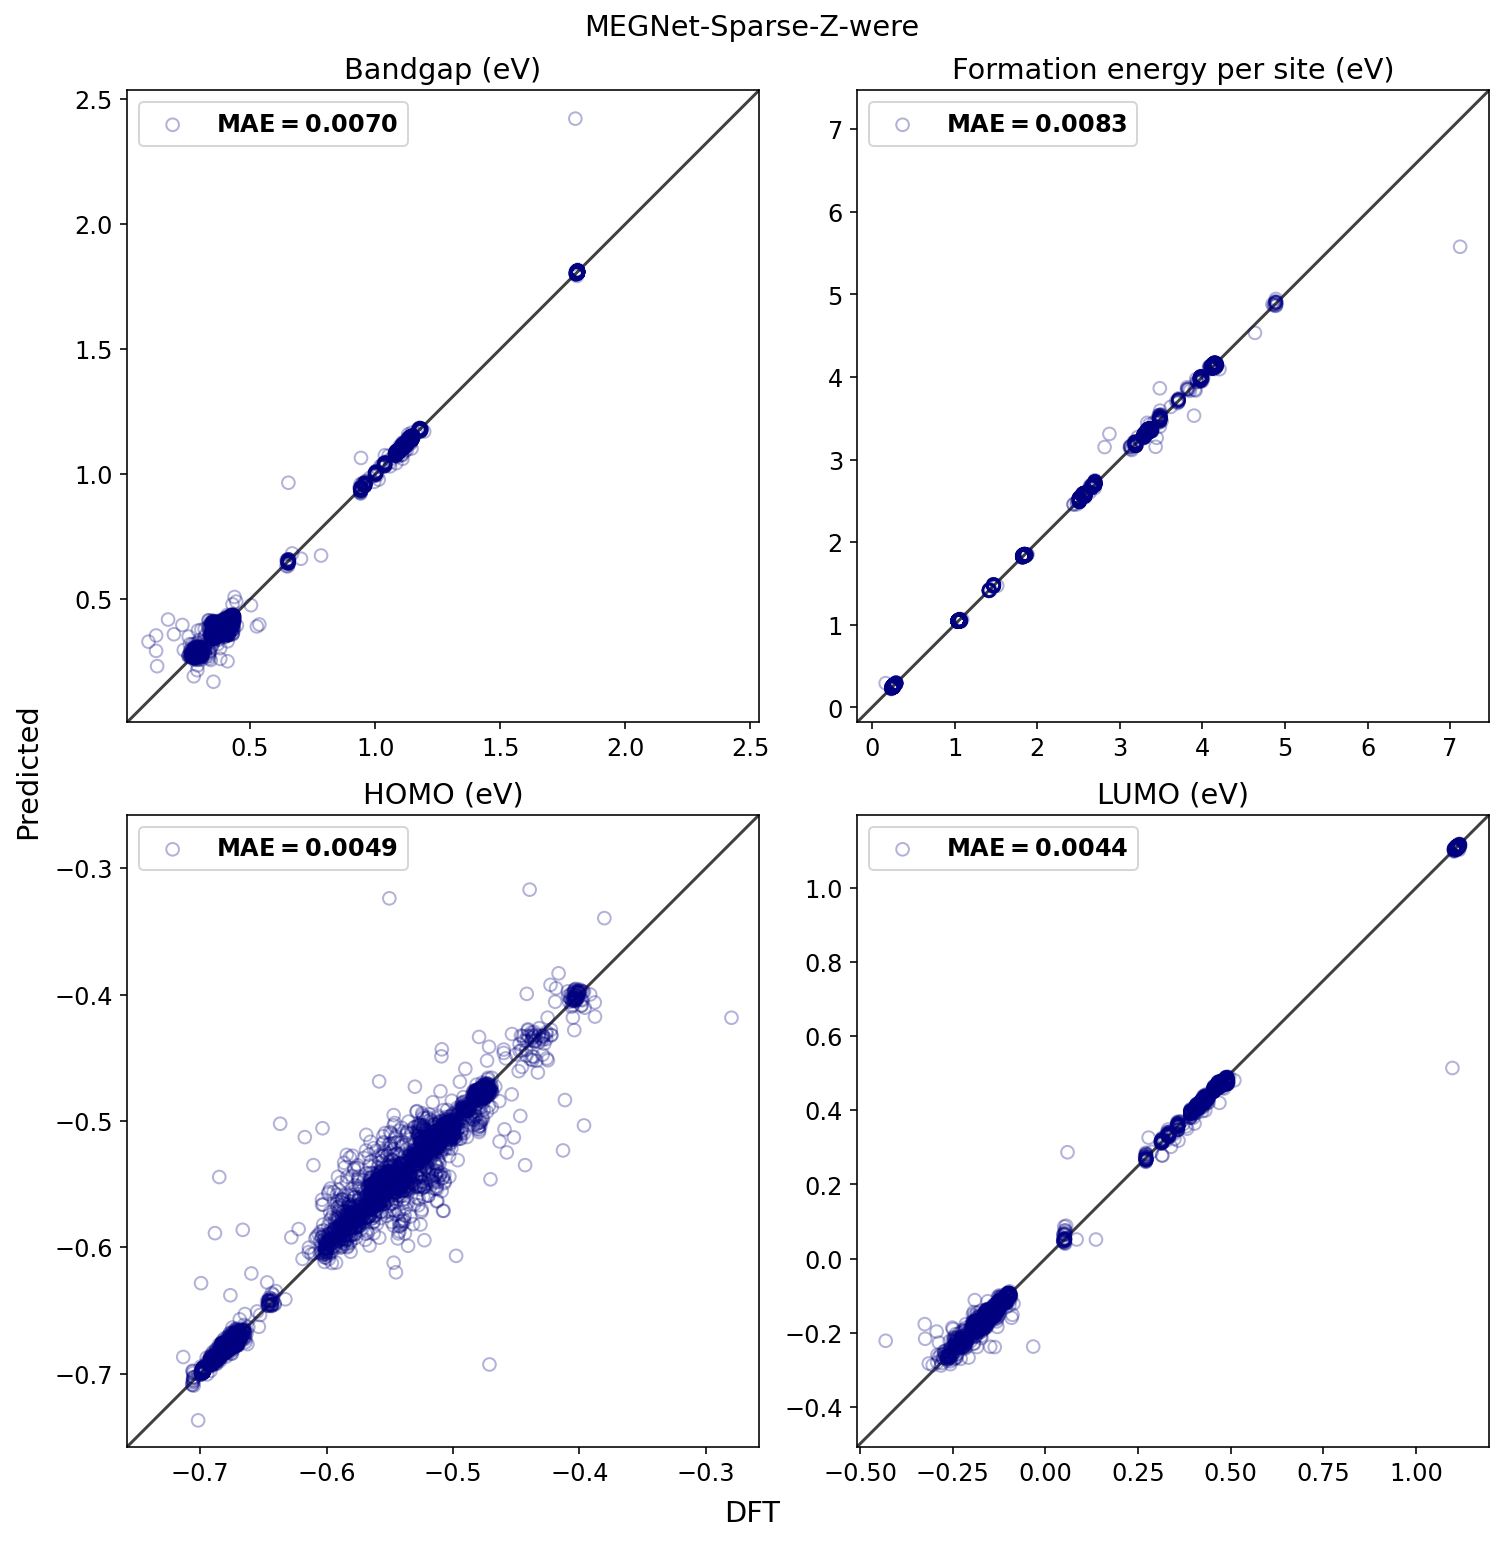

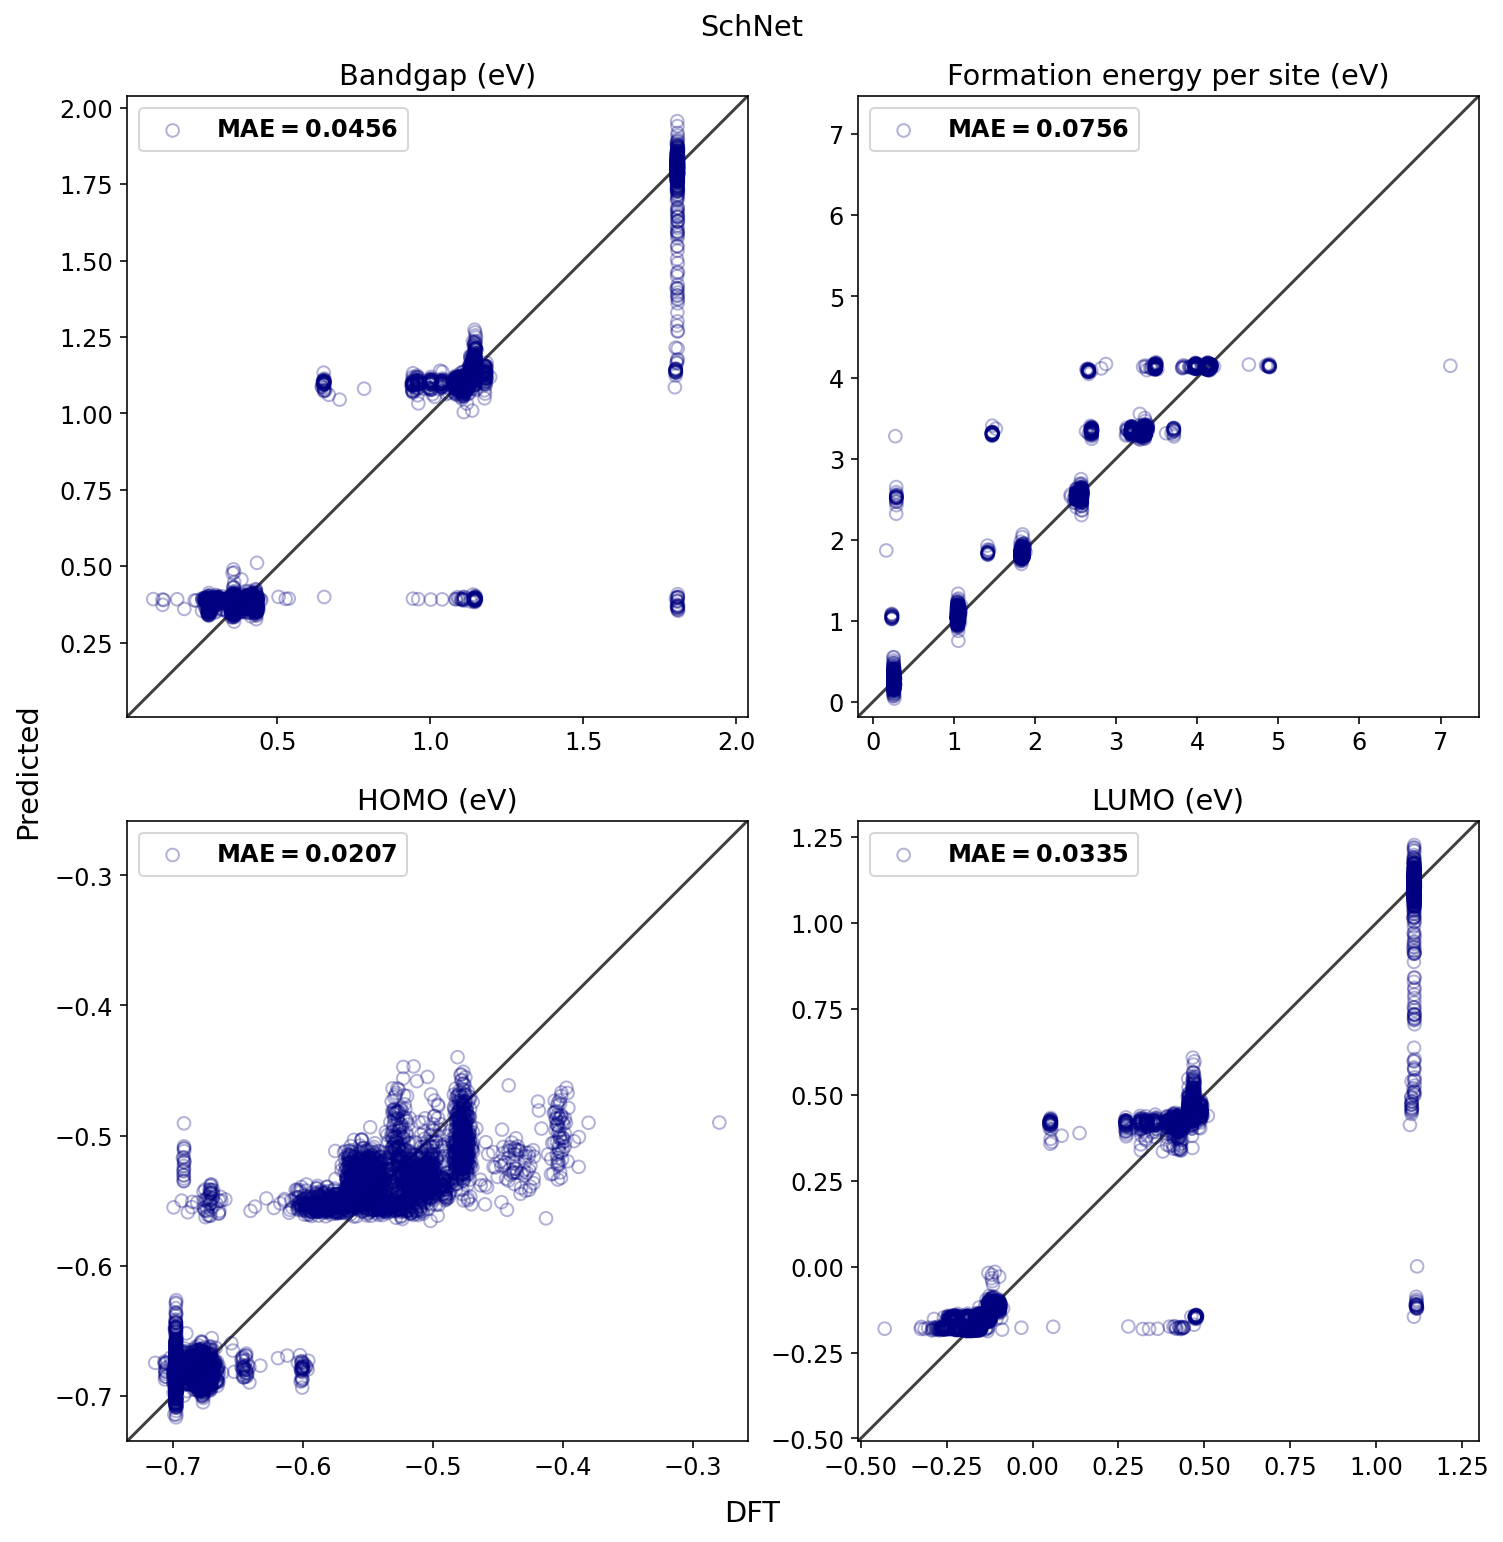

In [206]:
filenames = []
for experiment, _df in predictions.groupby(level=0, axis=1):
    if experiment == 'DFT': continue

    filenames.append(
        plot(
            predictions=predictions[experiment] / 1000,
            true_targets=predictions['DFT'] / 1000,
            experiment_name=experiment
    ))
    


In [184]:
def figure(between, caption):
    begin = r"\begin{figure}[htp!]"
    end = r"\end{figure}"
    body = [begin, '\n']
    for item in between:
        body.append(item)
        body.append('\n')
    if caption:
        body.append(f"\caption{{{caption}}}")
    body.extend(['\n' + end + '\n'])
    return ''.join(body)

def sub_figure(label, name, is_it_last=False):
    figure = r"\subcaptionbox{{ {label} \label{{ fig:{label} }} }} {{\includegraphics[width=\textwidth]{{ {name} }} }}".format(label=label, name=name)
    # spacer = "\hspace{0.1em}%"
    if is_it_last:
        return figure
    return figure #+ spacer


In [185]:
list_figures = []
# group by experiments
for i, (exper, files) in enumerate(groupby(filenames, lambda name: name.name.split('_')[0])):
    exper = exper.split('.')[0]
    print(
        figure(
            [sub_figure(f"{filename.stem.split('_')[-1]}", filename, is_it_last=i%2) for i,  filename in enumerate(files)],
            caption=f'{exper} predictions.'
        )
    )


\begin{figure}[htp!]
\subcaptionbox{ Catboost+Matminer \label{ fig:Catboost+Matminer } } {\includegraphics[width=\textwidth]{ plots/Catboost+Matminer.png } }
\caption{Catboost+Matminer predictions.}
\end{figure}

\begin{figure}[htp!]
\subcaptionbox{ GemNet \label{ fig:GemNet } } {\includegraphics[width=\textwidth]{ plots/GemNet.png } }
\caption{GemNet predictions.}
\end{figure}

\begin{figure}[htp!]
\subcaptionbox{ MEGNet-Full \label{ fig:MEGNet-Full } } {\includegraphics[width=\textwidth]{ plots/MEGNet-Full.png } }
\caption{MEGNet-Full predictions.}
\end{figure}

\begin{figure}[htp!]
\subcaptionbox{ MEGNet-Full-EOS \label{ fig:MEGNet-Full-EOS } } {\includegraphics[width=\textwidth]{ plots/MEGNet-Full-EOS.png } }
\caption{MEGNet-Full-EOS predictions.}
\end{figure}

\begin{figure}[htp!]
\subcaptionbox{ MEGNet-Sparse \label{ fig:MEGNet-Sparse } } {\includegraphics[width=\textwidth]{ plots/MEGNet-Sparse.png } }
\caption{MEGNet-Sparse predictions.}
\end{figure}

\begin{figure}[htp!]
\subca

# Model parameters

In [21]:
import yaml

In [352]:
for name in ['megnet', 'gemnet', 'schnet']:
    params = yaml.safe_load(open(f'../trials/{name}-full.yaml'))
    if name == 'megnet':
        print(pd.DataFrame.from_dict(params['model_params'], orient='index', columns=[f'{name} training parameters']).to_latex(label=name))
    else:
        print(pd.DataFrame.from_dict(params['model_params']['optim'], orient='index', columns=[f'{name} training parameters']).to_latex(label=name))

\begin{table}
\centering
\label{megnet}
\begin{tabular}{ll}
\toprule
{} & megnet training parameters \\
\midrule
add\_bond\_z\_coord   &                       True \\
atom\_features      &                          Z \\
learning\_rate      &                     0.0002 \\
epochs             &                        800 \\
nfeat\_edge\_per\_dim &                         10 \\
cutoff             &                          4 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\centering
\label{gemnet}
\begin{tabular}{ll}
\toprule
{} & gemnet training parameters \\
\midrule
max\_epochs         &                         50 \\
batch\_size         &                         32 \\
eval\_batch\_size    &                         32 \\
eval\_every         &                       5000 \\
num\_workers        &                          2 \\
lr\_initial         &                     0.0005 \\
optimizer          &                      AdamW \\
optimizer\_params   &          \{'amsgrad': True\} \\
sch